# 21 — Classement des Villes Françaises : Indice de Mobilité Douce

> **Dépendances** :  
> - `data/gbfs_france/` (notebook 20 — collecte GBFS)  
> - `output/19_ICT_Comparaison_Villes/tables_csv/ict_scores.csv` (optionnel, notebook 19)

---

## Objectif

Établir un **classement complet des villes françaises** selon leur niveau de développement en mobilité douce cyclable, en agrégeant l'ensemble des opérateurs SVLS présents dans chaque ville.

## Indice de Mobilité Douce (IMD)

L'IMD est un **indice composite multicritère** calculé à l'échelle de la ville :

$$\text{IMD} = 0.30 \cdot S_{\text{ville}} + 0.25 \cdot E_{\text{ville}} + 0.20 \cdot D_{\text{norm}} + 0.15 \cdot P_{\text{norm}} + 0.10 \cdot M_{\text{modal}}$$

| Composante | Poids | Description |
|:-----------|:-----:|:------------|
| **S** — Couverture spatiale | 30% | % de la zone SVLS couverte à ≤ 300m (union de tous les opérateurs à attaches) |
| **E** — Équité capacités | 25% | 1 − Gini, moyenne pondérée sur les systèmes à attaches de la ville |
| **D** — Densité | 20% | Stations à attaches / km² (log-normalisé sur l'ensemble des villes) |
| **P** — Offre / habitant | 15% | Stations à attaches / 1 000 hab. (log-normalisé) |
| **M** — Multi-modalité | 10% | Diversité des types d'offre (à attaches + free-floating + semi-dock) |

## Définitions
- **Système à attaches** (*dock-based*) : capacité moyenne ≥ 8 bornes/station
- **Semi-dock** : 2 ≤ capacité < 8 (bornes partagées, stations « légères »)
- **Free-floating** : capacité < 2 ou inconnue (trottinettes, vélos sans borne)

## 1. Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler

try:
    from shapely.geometry import MultiPoint
    HAS_SHAPELY = True
except ImportError:
    HAS_SHAPELY = False
    print('shapely non disponible — S_ville calculé par approximation bbox')

ROOT      = Path('../../')
OUT_DIR   = ROOT / 'data' / 'gbfs_france'
NB19_OUT  = ROOT / 'output' / '19_ICT_Comparaison_Villes' / 'tables_csv'
NB20_OUT  = ROOT / 'output' / '20_GBFS_France_Collecte' / 'tables_csv'
OUTPUT_NB = ROOT / 'output' / '21_Classement_Villes_Mobilite_Douce'

(OUTPUT_NB / 'figures').mkdir(parents=True, exist_ok=True)
(OUTPUT_NB / 'tables_csv').mkdir(exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
WALK_RADIUS_M = 300

# ── Palette IMD ────────────────────────────────────────────────────────────
CMAP_IMD   = plt.cm.RdYlGn
C_DOCK     = '#1565C0'   # bleu foncé
C_SEMI     = '#42A5F5'   # bleu clair
C_FF       = '#FF7043'   # orange

print('Setup OK')
print(f'Output → {OUTPUT_NB}')

Setup OK
Output → ..\..\output\21_Classement_Villes_Mobilite_Douce


## 2. Chargement et Classification des Systèmes

Trois types de mobilité douce sont distingués selon la capacité moyenne des stations.

Systèmes reclassifiés (virtuels → free-floating) : 40
                 system_id                      city                   system_name  n_stations      mob_type
                dott-paris                     Paris                    Dott Paris       14747 free-floating
                pony_paris                     Paris                    Pony Paris        3617 free-floating
             dott-bordeaux                  Bordeaux                 Dott Bordeaux        3449 free-floating
             bird-bordeaux                  Bordeaux                 Bird Bordeaux        3152 free-floating
             pony_bordeaux                  Bordeaux                 Pony Bordeaux        2996 free-floating
                 dott-lyon                      Lyon                     Dott Lyon        1404 free-floating
             voi_Marseille                 Marseille                 Voi Marseille        1268 free-floating
               pony_Angers                    Angers                   Pon

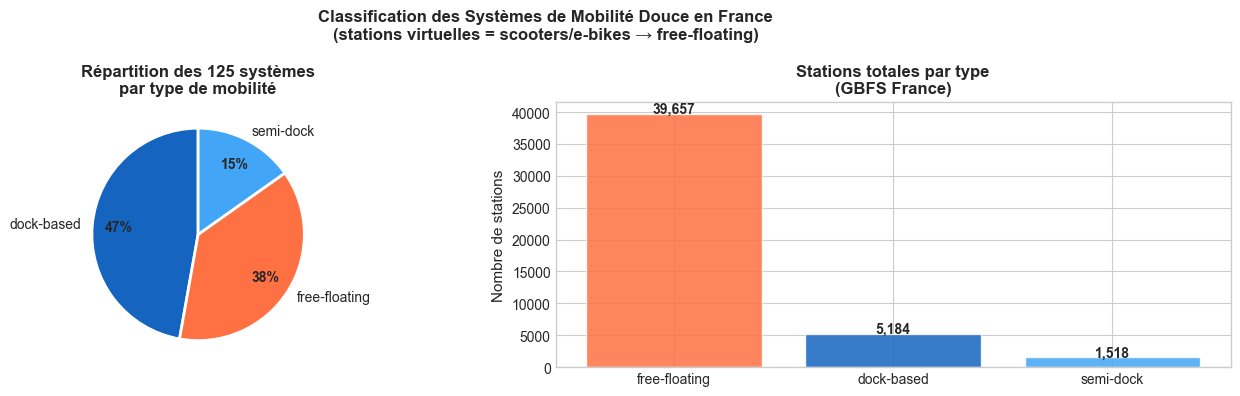


=== Classification ===
  dock-based     :  59 systèmes |  5,184 stations
  free-floating  :  47 systèmes | 39,657 stations
  semi-dock      :  19 systèmes |  1,518 stations


In [2]:
df_stations = pd.read_csv(OUT_DIR / 'stations_clean.csv')
df_profile  = pd.read_csv(NB20_OUT / 'systems_profile.csv')

# ── Normalisation des noms de villes ───────────────────────────────────────
CITY_NORM = {
    'Nice, FR':              'Nice',
    'Strasbourg, FR':        'Strasbourg',
    "Saint-Pierre, L'Étang-Salé & Saint-Louis": 'La Réunion',
    'Basque Country':        'Pays Basque',
    'Herouville-Saint-Clair':'Hérouville-Saint-Clair',
    'Ol-Vallee':             'Ol-Vallée',
    'Argeles-sur-Mer':       'Argelès-sur-Mer',
    'Arundy':                'Vallée d\'Ossau',
}
SKIP_CITIES = {'FR', 'Grand Est', 'France (national)', 'Inconnu', '', 'France',
               'Allègre', 'Lascaux', 'Courzieu', "Vallée d'Ossau"}

def normalize_city(city):
    if not isinstance(city, str) or not city.strip():
        return 'Inconnu'
    return CITY_NORM.get(city.strip(), city.strip())

df_profile['city_n'] = df_profile['city'].apply(normalize_city)
df_stations['city_n'] = df_stations['city'].apply(normalize_city)

# ── Détection des stations virtuelles (scooters/e-bikes free-floating) ─────
# Les opérateurs type VOI, Dott, Bird, Pony utilisent des "virtual stations"
# (zones géo-délimitées) avec grande capacité → seraient à tort classés dock-based
# sans ce filtre. On lit is_virtual_station depuis les JSON bruts.
import json as _json
_raw_dir = ROOT / 'data' / 'gbfs_france' / 'raw'
_pct_virtual = {}
for _sys_id in df_profile['system_id']:
    _jpath = _raw_dir / str(_sys_id) / 'station_information.json'
    if not _jpath.exists():
        _pct_virtual[_sys_id] = 0.0
        continue
    try:
        with open(_jpath, encoding='utf-8', errors='replace') as _f:
            _d = _json.load(_f)
        _sts = _d.get('data', {}).get('stations', [])
        _pct_virtual[_sys_id] = (
            sum(1 for s in _sts if s.get('is_virtual_station', False)) / max(len(_sts), 1)
        )
    except Exception:
        _pct_virtual[_sys_id] = 0.0

df_profile['pct_virtual'] = df_profile['system_id'].map(_pct_virtual).fillna(0.0)

# ── Classification des systèmes ────────────────────────────────────────────
# Règle : dock-based ssi mean_capacity ≥ 8 ET < 80 % stations virtuelles
def classify_system(row):
    mean_cap  = row['mean_capacity']
    pct_virt  = row['pct_virtual']
    # Systèmes à stations purement virtuelles → free-floating peu importe la capacité
    if pct_virt > 0.80:
        return 'free-floating'
    if pd.isna(mean_cap) or mean_cap < 2:
        return 'free-floating'
    elif mean_cap < 8:
        return 'semi-dock'
    else:
        return 'dock-based'

df_profile['mob_type'] = df_profile.apply(classify_system, axis=1)

# Résumé des reclassifications
n_virt_reclassified = (df_profile['pct_virtual'] > 0.80).sum()
print(f'Systèmes reclassifiés (virtuels → free-floating) : {n_virt_reclassified}')
virt_sys = df_profile[df_profile['pct_virtual'] > 0.80][['system_id', 'city', 'system_name', 'n_stations', 'mob_type']]
print(virt_sys.to_string(index=False))

# ── Vue d'ensemble ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

type_counts = df_profile['mob_type'].value_counts()
ax = axes[0]
wedges, texts, autotexts = ax.pie(
    type_counts.values,
    labels=type_counts.index,
    autopct='%1.0f%%',
    colors=[C_DOCK, C_FF, C_SEMI][:len(type_counts)],
    startangle=90, pctdistance=0.75,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)
for t in autotexts:
    t.set_fontweight('bold')
ax.set_title(f'Répartition des {len(df_profile)} systèmes\npar type de mobilité', fontweight='bold')

# Stations par type
ax2 = axes[1]
type_stations = df_profile.groupby('mob_type')['n_stations'].sum().sort_values(ascending=False)
colors_bar = {'dock-based': C_DOCK, 'semi-dock': C_SEMI, 'free-floating': C_FF}
bars = ax2.bar(type_stations.index, type_stations.values,
               color=[colors_bar.get(t, 'gray') for t in type_stations.index],
               alpha=0.85, edgecolor='white')
for bar, v in zip(bars, type_stations.values):
    ax2.text(bar.get_x() + bar.get_width()/2, v + 200, f'{v:,}',
             ha='center', fontweight='bold', fontsize=10)
ax2.set_ylabel('Nombre de stations', fontsize=11)
ax2.set_title('Stations totales par type\n(GBFS France)', fontweight='bold')

plt.suptitle('Classification des Systèmes de Mobilité Douce en France\n'
             '(stations virtuelles = scooters/e-bikes → free-floating)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '01_classification_types.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Classification ===' )
for t, cnt in type_counts.items():
    n_st = type_stations.get(t, 0)
    print(f'  {t:15s}: {cnt:3d} systèmes | {n_st:6,} stations')

## 3. Vue d'Ensemble par Ville — Multi-Opérateurs

Agrégation de **tous les opérateurs** présents dans chaque ville.

In [3]:
dock_ids = df_profile[df_profile['mob_type'] == 'dock-based']['system_id'].tolist()
semi_ids = df_profile[df_profile['mob_type'] == 'semi-dock']['system_id'].tolist()
ff_ids   = df_profile[df_profile['mob_type'] == 'free-floating']['system_id'].tolist()

df_dock_st = df_stations[df_stations['system_id'].isin(dock_ids)].copy()

city_rows = []
all_cities = [c for c in df_profile['city_n'].unique() if c not in SKIP_CITIES]

for city in all_cities:
    s = df_profile[df_profile['city_n'] == city]
    dock = s[s['mob_type'] == 'dock-based']
    semi = s[s['mob_type'] == 'semi-dock']
    ff   = s[s['mob_type'] == 'free-floating']

    n_dock = int(dock['n_stations'].sum())
    n_semi = int(semi['n_stations'].sum())
    n_ff   = int(ff['n_stations'].sum())
    n_total= n_dock + n_semi + n_ff

    if n_total == 0:
        continue

    # Équité pondérée (dock en priorité, semi-dock en fallback)
    if len(dock) > 0 and dock['n_stations'].sum() > 0:
        e_dock = (dock['E_ict'] * dock['n_stations']).sum() / dock['n_stations'].sum()
    elif len(semi) > 0 and semi['n_stations'].sum() > 0:
        e_dock = (semi['E_ict'] * semi['n_stations']).sum() / semi['n_stations'].sum()
    else:
        e_dock = np.nan
    # Capacité totale (dock)
    total_cap = int(dock['total_capacity'].sum()) if 'total_capacity' in dock.columns else 0

    # Densité : dock en priorité, semi-dock en fallback
    if len(dock) > 0 and dock['density_st_km2'].notna().any():
        density_best = dock['density_st_km2'].max()
    elif len(semi) > 0 and semi['density_st_km2'].notna().any():
        density_best = semi['density_st_km2'].max()
    else:
        density_best = np.nan

    # Nb types
    types = set()
    if n_dock > 0: types.add('dock')
    if n_semi > 0: types.add('semi')
    if n_ff   > 0: types.add('free')

    city_rows.append({
        'city':          city,
        'n_dock':        n_dock,
        'n_semi':        n_semi,
        'n_ff':          n_ff,
        'n_total':       n_total,
        'n_operators':   len(s),
        'n_dock_ops':    len(dock),
        'total_cap_dock':total_cap,
        'E_dock':        round(e_dock, 4) if not np.isnan(e_dock) else np.nan,
        'n_types':       len(types),
        'density_dock':  density_best,
        'dock_names':    ' + '.join(dock['system_name'].tolist()) or '—',
    })

df_city = (
    pd.DataFrame(city_rows)
    .sort_values('n_dock', ascending=False)
    .reset_index(drop=True)
)

print(f'=== {len(df_city)} villes avec offre SVLS ===')
print(df_city[['city', 'n_dock', 'n_semi', 'n_ff', 'n_total', 'n_operators', 'E_dock']]
      .head(25).to_string(index=False))

=== 90 villes avec offre SVLS ===
                 city  n_dock  n_semi  n_ff  n_total  n_operators  E_dock
                Paris    1507       0 18364    19871            3  0.7939
                 Lyon     452     201  1404     2057            3  0.8124
             Toulouse     434       0   128      562            2  0.8694
                Lille     268      77     0      345            2  0.8162
             Bordeaux     225      99  9597     9921            5  0.7834
            Marseille     221      98  2071     2390            4  0.8403
               Nantes     124       0    41      165            2  0.8091
               Épinal     105       0     0      105            1  0.9470
        Saint-Étienne      97       0     0       97            1  0.7724
               Calais      89       0     0       89            2  0.7762
     Clermont-Ferrand      82       0     0       82            1  0.8533
               Annecy      80       0     0       80            1  0.9089
    

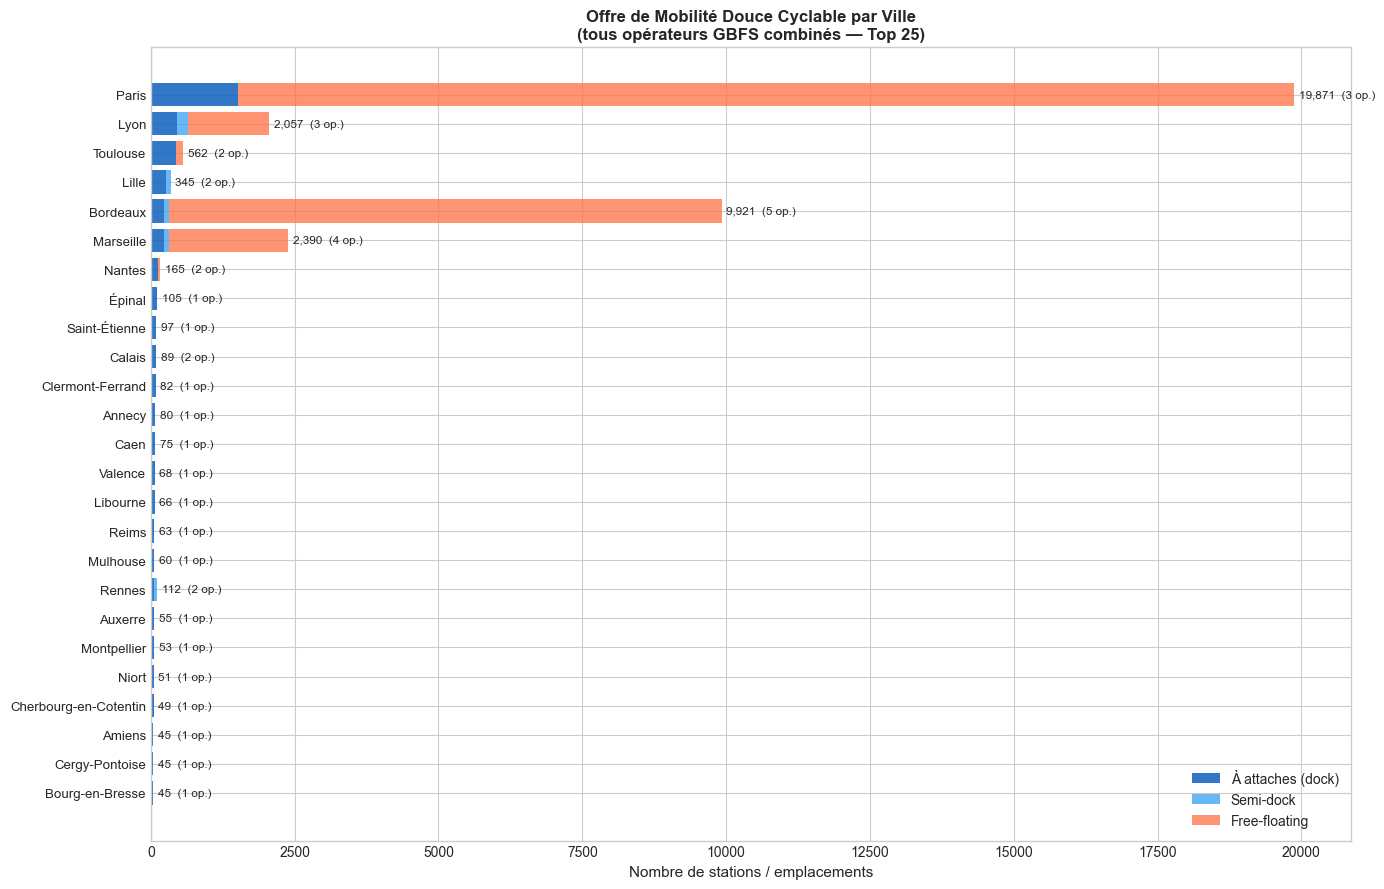

In [4]:
# Visualisation de l'offre combinée — Top 25 villes
top25 = df_city.head(25).copy()
labels_c = top25['city'].tolist()

fig, ax = plt.subplots(figsize=(14, 9))
y = np.arange(len(top25))

bar_dock = ax.barh(y, top25['n_dock'], color=C_DOCK, alpha=0.88, label='À attaches (dock)')
bar_semi = ax.barh(y, top25['n_semi'], left=top25['n_dock'],
                   color=C_SEMI, alpha=0.80, label='Semi-dock')
bar_ff   = ax.barh(y, top25['n_ff'],   left=top25['n_dock'] + top25['n_semi'],
                   color=C_FF, alpha=0.75, label='Free-floating')

# Annotations total
for i, (_, row) in enumerate(top25.iterrows()):
    total = row['n_total']
    ax.text(total + 80, i, f'{total:,}  ({row["n_operators"]} op.)',
            va='center', fontsize=8.5)

ax.set_yticks(y)
ax.set_yticklabels(labels_c, fontsize=9.5)
ax.set_xlabel('Nombre de stations / emplacements', fontsize=11)
ax.set_title('Offre de Mobilité Douce Cyclable par Ville\n'
             '(tous opérateurs GBFS combinés — Top 25)',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '02_offre_par_ville.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Offre par Habitant

Indicateur clé d'**accessibilité démocratique** : un système dense mais dans une grande ville peut être sous-dimensionné.

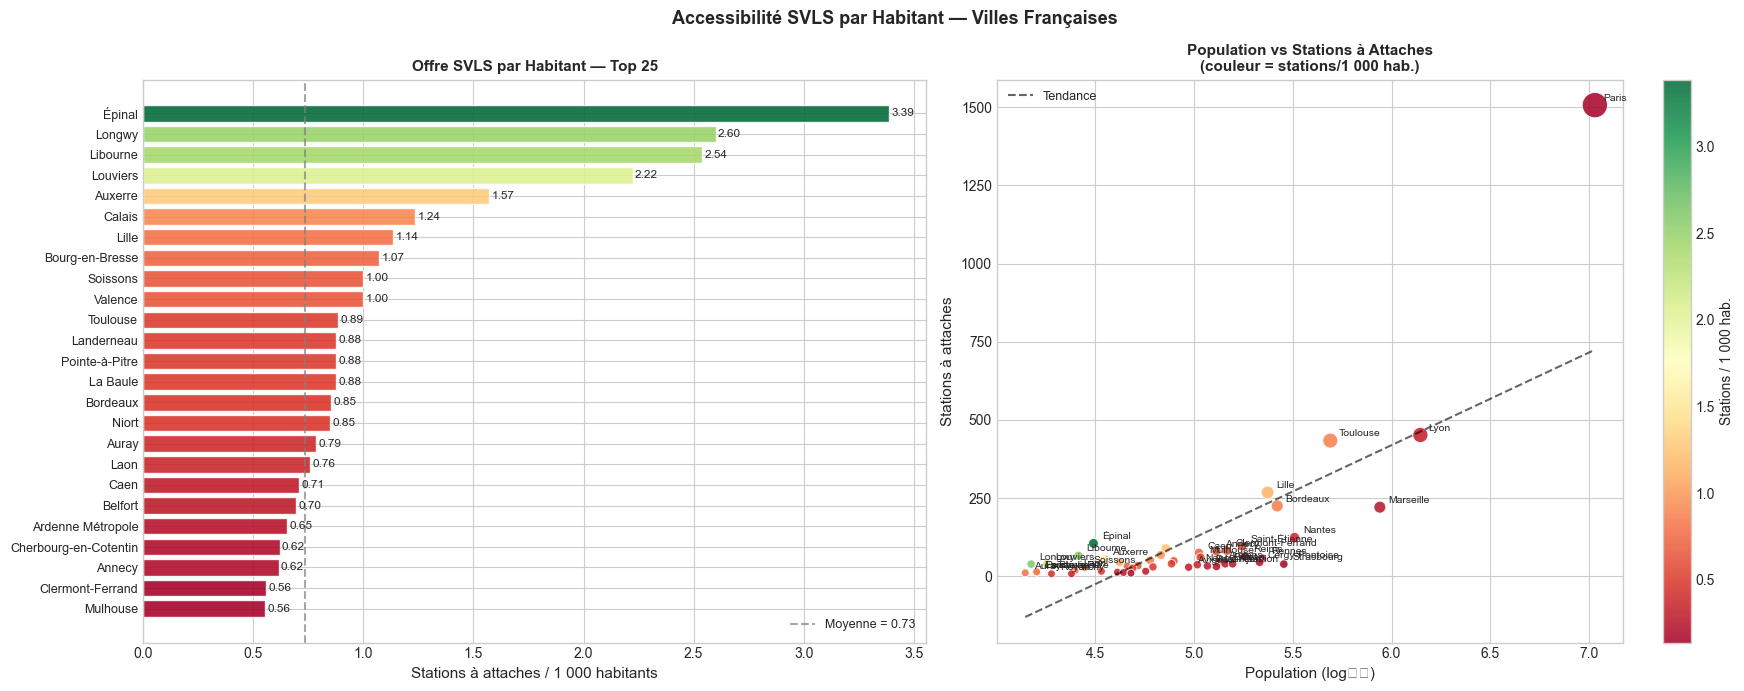

Villes avec données population : 51
Offre moyenne : 0.73 stations/1 000 hab.

Sur-performeurs (≥ 2× moyenne) :
    city  n_dock  population  dock_per_1k_hab
  Épinal     105     31000.0         3.387097
  Longwy      39     15000.0         2.600000
Libourne      66     26000.0         2.538462
Louviers      40     18000.0         2.222222
 Auxerre      55     35000.0         1.571429


In [5]:
# Population des principales villes françaises (communes / unités urbaines, 2023)
CITY_POP = {
    'Paris':                   10_700_000,  # Grand Paris
    'Lyon':                     1_400_000,  # Métropole
    'Marseille':                  873_000,
    'Toulouse':                   490_000,
    'Nice':                       344_000,
    'Nantes':                     323_000,
    'Bordeaux':                   264_000,
    'Lille':                      236_000,
    'Strasbourg':                 285_000,
    'Grenoble':                   160_000,
    'Rennes':                     222_000,
    'Le Havre':                   171_000,
    'Saint-Étienne':              175_000,
    'Reims':                      181_000,
    'Angers':                     154_000,
    'Clermont-Ferrand':           147_000,
    'Amiens':                     135_000,
    'Mulhouse':                   108_000,
    'Caen':                       106_000,
    'Nancy':                      104_000,
    'Rouen':                      112_000,
    'Brest':                      144_000,
    'Metz':                       118_000,
    'Besançon':                   117_000,
    'Limoges':                    130_000,
    'Dijon':                      157_000,
    'Annecy':                     130_000,
    'La Rochelle':                 79_000,
    'Poitiers':                    90_000,
    'Avignon':                     94_000,
    'Perpignan':                  122_000,
    'Épinal':                      31_000,
    'Calais':                      72_000,
    'Niort':                       60_000,
    'Troyes':                      62_000,
    'Valence':                     68_000,
    'Auxerre':                     35_000,
    'Belfort':                     46_000,
    'Tarbes':                      41_000,
    'Agen':                        34_000,
    'Bourg-en-Bresse':             42_000,
    'Cergy-Pontoise':             215_000,
    'Saint-Quentin-en-Yvelines':  240_000,
    'Grand Paris Seine et Oise':  420_000,
    'Marne-la-Vallée':            350_000,
    'Versailles':                  86_000,
    'Cherbourg-en-Cotentin':       79_000,
    'Carcassonne':                 48_000,
    'Saint-Nazaire':               72_000,
    'Cholet':                      57_000,
    'Brive-la-Gaillarde':          49_000,
    'Vichy':                       24_000,
    'Louviers':                    18_000,
    'Soissons':                    28_000,
    'Laon':                        25_000,
    'Longwy':                      15_000,
    'Beauvais':                    56_000,
    'Libourne':                    26_000,
    'Ajaccio':                     71_000,
    'Draguignan':                  40_000,
    'Royan':                       19_000,
    'Périgueux':                   30_000,
    'La Baule':                    16_000,
    'Saint-Brieuc':                44_000,
    'Châtellerault':               32_000,
    'Auray':                       14_000,
    'Nancy':                      104_000,
    'Ardenne Métropole':           52_000,
    'La Roche-sur-Yon':            55_000,
    'Landerneau':                  16_000,
    'Pointe-à-Pitre':              16_000,
    'Pays Basque':                320_000,
    'Hérouville-Saint-Clair':      21_000,
    'Lorient':                     57_000,
    'Bourges':                     65_000,
    'Gap':                         40_000,
    'Sarreguemines':               21_000,
    'Millau':                      22_000,
    'Pau':                         77_000,
    'PAU':                         77_000,
    'Évry':                        55_000,
    'Evry':                        55_000,
    # Nouvelles villes — seuil étendu dock+semi >= 3
    'Valenciennes':            190_000,
    'Montreuil-Bellay':          4_000,
    'La Réunion':             130_000,
    "Argelès-sur-Mer":         12_000,
}

df_city['population'] = df_city['city'].map(CITY_POP)
df_city['dock_per_1k_hab'] = (
    df_city['n_dock'] / df_city['population'] * 1000
).where(df_city['population'].notna())
df_city['cap_per_1k_hab'] = (
    df_city['total_cap_dock'] / df_city['population'] * 1000
).where(df_city['population'].notna())

df_pop = df_city.dropna(subset=['dock_per_1k_hab']).copy()
df_pop = df_pop[df_pop['n_dock'] >= 8].sort_values('dock_per_1k_hab', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Stations dock / 1000 hab ---
ax = axes[0]
top_pop = df_pop.head(25)
norm_c  = plt.Normalize(top_pop['dock_per_1k_hab'].min(), top_pop['dock_per_1k_hab'].max())
cols    = [CMAP_IMD(norm_c(v)) for v in top_pop['dock_per_1k_hab']]

bars = ax.barh(range(len(top_pop)), top_pop['dock_per_1k_hab'], color=cols,
               alpha=0.88, edgecolor='white')
ax.set_yticks(range(len(top_pop)))
ax.set_yticklabels(top_pop['city'], fontsize=9)
ax.set_xlabel('Stations à attaches / 1 000 habitants', fontsize=11)
ax.set_title('Offre SVLS par Habitant — Top 25', fontsize=11, fontweight='bold')
ax.axvline(df_pop['dock_per_1k_hab'].mean(), color='gray', lw=1.5, ls='--', alpha=0.7,
           label=f'Moyenne = {df_pop["dock_per_1k_hab"].mean():.2f}')
ax.legend(fontsize=9)
ax.invert_yaxis()
for i, v in enumerate(top_pop['dock_per_1k_hab']):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=8.5)

# --- Scatter : n_dock vs population ----
ax2 = axes[1]
sc = ax2.scatter(
    np.log10(df_pop['population']),
    df_pop['n_dock'],
    c=df_pop['dock_per_1k_hab'],
    cmap=CMAP_IMD, s=df_pop['n_dock'] / 5 + 30,
    alpha=0.85, edgecolors='white', linewidths=0.7
)
plt.colorbar(sc, ax=ax2, label='Stations / 1 000 hab.')

# Ligne de tendance
x_fit = np.log10(df_pop['population'].values)
z = np.polyfit(x_fit, df_pop['n_dock'].values, 1)
p = np.poly1d(z)
x_range = np.linspace(x_fit.min(), x_fit.max(), 100)
ax2.plot(x_range, p(x_range), 'k--', lw=1.5, alpha=0.6, label='Tendance')

# Sur/sous-performeurs
df_pop['expected'] = p(np.log10(df_pop['population']))
df_pop['delta']    = df_pop['n_dock'] - df_pop['expected']

for _, row in df_pop.iterrows():
    if abs(row['delta']) > 50 or row['n_dock'] > 200:
        ax2.annotate(row['city'],
                     (np.log10(row['population']), row['n_dock']),
                     textcoords='offset points', xytext=(6, 3), fontsize=7.5)

ax2.set_xlabel('Population (log₁₀)', fontsize=11)
ax2.set_ylabel('Stations à attaches', fontsize=11)
ax2.set_title('Population vs Stations à Attaches\n(couleur = stations/1 000 hab.)',
              fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)

plt.suptitle('Accessibilité SVLS par Habitant — Villes Françaises',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '03_offre_par_habitant.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Villes avec données population : {df_pop["city"].nunique()}')
print(f'Offre moyenne : {df_pop["dock_per_1k_hab"].mean():.2f} stations/1 000 hab.')
print(f'\nSur-performeurs (≥ 2× moyenne) :')
print(df_pop[df_pop['dock_per_1k_hab'] >= df_pop['dock_per_1k_hab'].mean() * 2]
      [['city', 'n_dock', 'population', 'dock_per_1k_hab']].to_string(index=False))

## 5. S_géom au Niveau Ville

La couverture spatiale est calculée sur **l'union de tous les systèmes à attaches** d'une ville,  
ce qui est plus représentatif que de prendre un seul opérateur.

In [6]:
def compute_coverage_s(lats, lons, radius_m=300, grid_m=150):
    """Couverture spatiale raster-numpy vectorisée."""
    if len(lats) < 2:
        return 1.0
    lat_c = lats.mean()
    x = (lons - lons.min()) * (111_320.0 * np.cos(np.radians(lat_c)))
    y = (lats - lats.min()) * 111_132.0
    ix = np.floor(x / grid_m).astype(int)
    iy = np.floor(y / grid_m).astype(int)
    r_cells = int(np.ceil(radius_m / grid_m))
    off = np.arange(-r_cells, r_cells + 1)
    dxs, dys = np.meshgrid(off, off)
    cm = (dxs**2 + dys**2) <= (radius_m / grid_m)**2
    dxs_c, dys_c = dxs[cm].ravel(), dys[cm].ravel()
    all_cx = (ix[:, None] + dxs_c[None, :]).ravel()
    all_cy = (iy[:, None] + dys_c[None, :]).ravel()
    packed = all_cx.astype(np.int64) * 100_000 + all_cy.astype(np.int64)
    n_covered = len(np.unique(packed))
    if HAS_SHAPELY:
        hull_area = MultiPoint(list(zip(x, y))).convex_hull.area
    else:
        hull_area = (x.max() - x.min()) * (y.max() - y.min())
    if hull_area < grid_m**2:
        return 1.0
    return float(np.clip(n_covered / (hull_area / grid_m**2), 0.0, 1.0))


# Étendre avec semi-dock pour villes sans stations dock suffisantes
df_semi_st_all = df_stations[df_stations['system_id'].isin(semi_ids)].copy()
cities_need_semi = df_city[df_city['n_dock'] < 3]['city'].tolist()
df_dock_semi_ext = pd.concat([
    df_dock_st,
    df_semi_st_all[df_semi_st_all['city_n'].isin(cities_need_semi)]
], ignore_index=True)

print(f'Calcul S_ville pour {df_city["city"].nunique()} villes (dock + semi-dock étendu)...')

s_city_rows = []
for _, row in df_city.iterrows():
    city = row['city']
    n_eff = int(row['n_dock']) + int(row.get('n_semi', 0))
    if n_eff < 3:
        s_city_rows.append({'city': city, 'S_ville': np.nan})
        continue
    grp = df_dock_semi_ext[df_dock_semi_ext['city_n'] == city]
    if len(grp) < 3:
        s_city_rows.append({'city': city, 'S_ville': np.nan})
        continue
    s = compute_coverage_s(grp['lat'].values, grp['lon'].values)
    s_city_rows.append({'city': city, 'S_ville': round(s, 4)})

df_s_city = pd.DataFrame(s_city_rows)
df_city = df_city.merge(df_s_city, on='city', how='left')

print('Terminé.')
print(f'S_ville moyen  : {df_city["S_ville"].mean():.4f}')
print(f'S_ville médian : {df_city["S_ville"].median():.4f}')
print(f'\nTop 10 couverture spatiale :')
print(df_city[df_city['n_dock'] >= 20].nlargest(10, 'S_ville')
      [['city', 'n_dock', 'S_ville', 'E_dock']].to_string(index=False))

Calcul S_ville pour 90 villes (dock + semi-dock étendu)...


Terminé.
S_ville moyen  : 0.2736
S_ville médian : 0.2220

Top 10 couverture spatiale :
           city  n_dock  S_ville  E_dock
          Nancy      37   0.8112  0.8709
         Nantes     124   0.7855  0.8091
         Amiens      45   0.7495  0.8313
         Rennes      57   0.6312  0.8574
          Paris    1507   0.4606  0.7939
          Dijon      40   0.4584  0.8380
 Cergy-Pontoise      45   0.4451  0.8789
Bourg-en-Bresse      45   0.4137  0.7959
          Lille     268   0.4118  0.8162
       Bordeaux     225   0.3966  0.7834


## 6. Indice de Mobilité Douce (IMD) — Calcul Composite

In [7]:
# ── Composantes brutes ─────────────────────────────────────────────────────
df_imd = df_city.copy()

# C1 : S_ville (déjà 0-1)
df_imd['C1_S'] = df_imd['S_ville'].fillna(0)

# C2 : E_dock (déjà 0-1)
df_imd['C2_E'] = df_imd['E_dock'].fillna(0)

# C3 : Densité dock (log + normalisation min-max)
df_imd['log_density'] = np.log1p(df_imd['density_dock'].fillna(0))
d_min, d_max = df_imd['log_density'].min(), df_imd['log_density'].max()
df_imd['C3_D'] = (df_imd['log_density'] - d_min) / max(d_max - d_min, 1e-9)

# C4 : Offre / habitant (log + normalisation)
df_imd['log_per_hab'] = np.log1p(df_imd['dock_per_1k_hab'].fillna(np.nan))
p_min, p_max = df_imd['log_per_hab'].min(), df_imd['log_per_hab'].max()
df_imd['C4_P'] = (df_imd['log_per_hab'] - p_min) / max(p_max - p_min, 1e-9)

# C5 : Multi-modalité (0, 1/3, 2/3, 1)
df_imd['C5_M'] = df_imd['n_types'] / 3.0

# ── IMD pondéré ────────────────────────────────────────────────────────────
# Poids optimisés via NB25 (Opt. Combinée FUB+EMP, differential_evolution)
# ρ(FUB)=0.473, ρ(EMP)=0.475  vs  normatif ρ(FUB)=0.162, ρ(EMP)=0.260
W = {'C1_S': 0.1839, 'C2_E': 0.0689, 'C3_D': 0.0511, 'C4_P': 0.1184, 'C5_M': 0.5776}

def compute_imd(row):
    """IMD avec ajustement si C4_P est inconnu."""
    if pd.isna(row.get('dock_per_1k_hab')):
        # Sans population : redistribuer les 15% de C4 sur S et E
        s = row['C1_S'] * 0.2086 + row['C2_E'] * 0.0782 + row['C3_D'] * 0.0580 + row['C5_M'] * 0.6552
        return round(s, 4)
    numerator = sum(row[c] * w for c, w in W.items())
    return round(numerator, 4)

df_imd['IMD'] = df_imd.apply(compute_imd, axis=1)

# Seuil étendu : villes avec (dock + semi-dock) >= 3
df_imd = df_imd[(df_imd['n_dock'] + df_imd['n_semi']) >= 3].copy()
df_imd = df_imd.sort_values('IMD', ascending=False).reset_index(drop=True)
df_imd.index += 1
df_imd.index.name = 'rang'   # FIX: nommer l'index pour que reset_index() crée 'rang' correctement

df_imd.to_csv(OUTPUT_NB / 'tables_csv' / 'imd_classement.csv', index_label='rang')

print(f'=== Classement IMD ({len(df_imd)} villes) ===')
print(df_imd[['city', 'n_dock', 'S_ville', 'E_dock', 'C3_D', 'C4_P', 'C5_M', 'IMD']]
      .head(20)
      .rename(columns={'S_ville':'S', 'E_dock':'E', 'C3_D':'D_norm', 'C4_P':'P_norm', 'C5_M':'M'})
      .to_string())

=== Classement IMD (62 villes) ===
                  city  n_dock       S       E    D_norm    P_norm         M     IMD
rang                                                                                
1             Bordeaux     225  0.3966  0.7834  0.652167  0.416871  1.000000  0.7872
2            Marseille     221  0.3778  0.8403  0.619414  0.152611  1.000000  0.7547
3               Nantes     124  0.7855  0.8091  1.000000  0.219729  0.666667  0.6624
4                 Lyon     452  0.0215  0.8124  0.006115  0.189220  1.000000  0.6602
5               Rennes      57  0.6312  0.8574  0.836352  0.154554  0.666667  0.6213
6                Lille     268  0.4118  0.8162  0.565535  0.513127  0.666667  0.6067
7     La Roche-sur-Yon       0  0.6159  0.8304  0.687292  0.000000  0.666667  0.5907
8                Paris    1507  0.4606  0.7939  0.845734  0.089111  0.666667  0.5782
9              Belfort      32  0.3313  0.7467  0.429020  0.357124  0.666667  0.5616
10            Toulouse     434

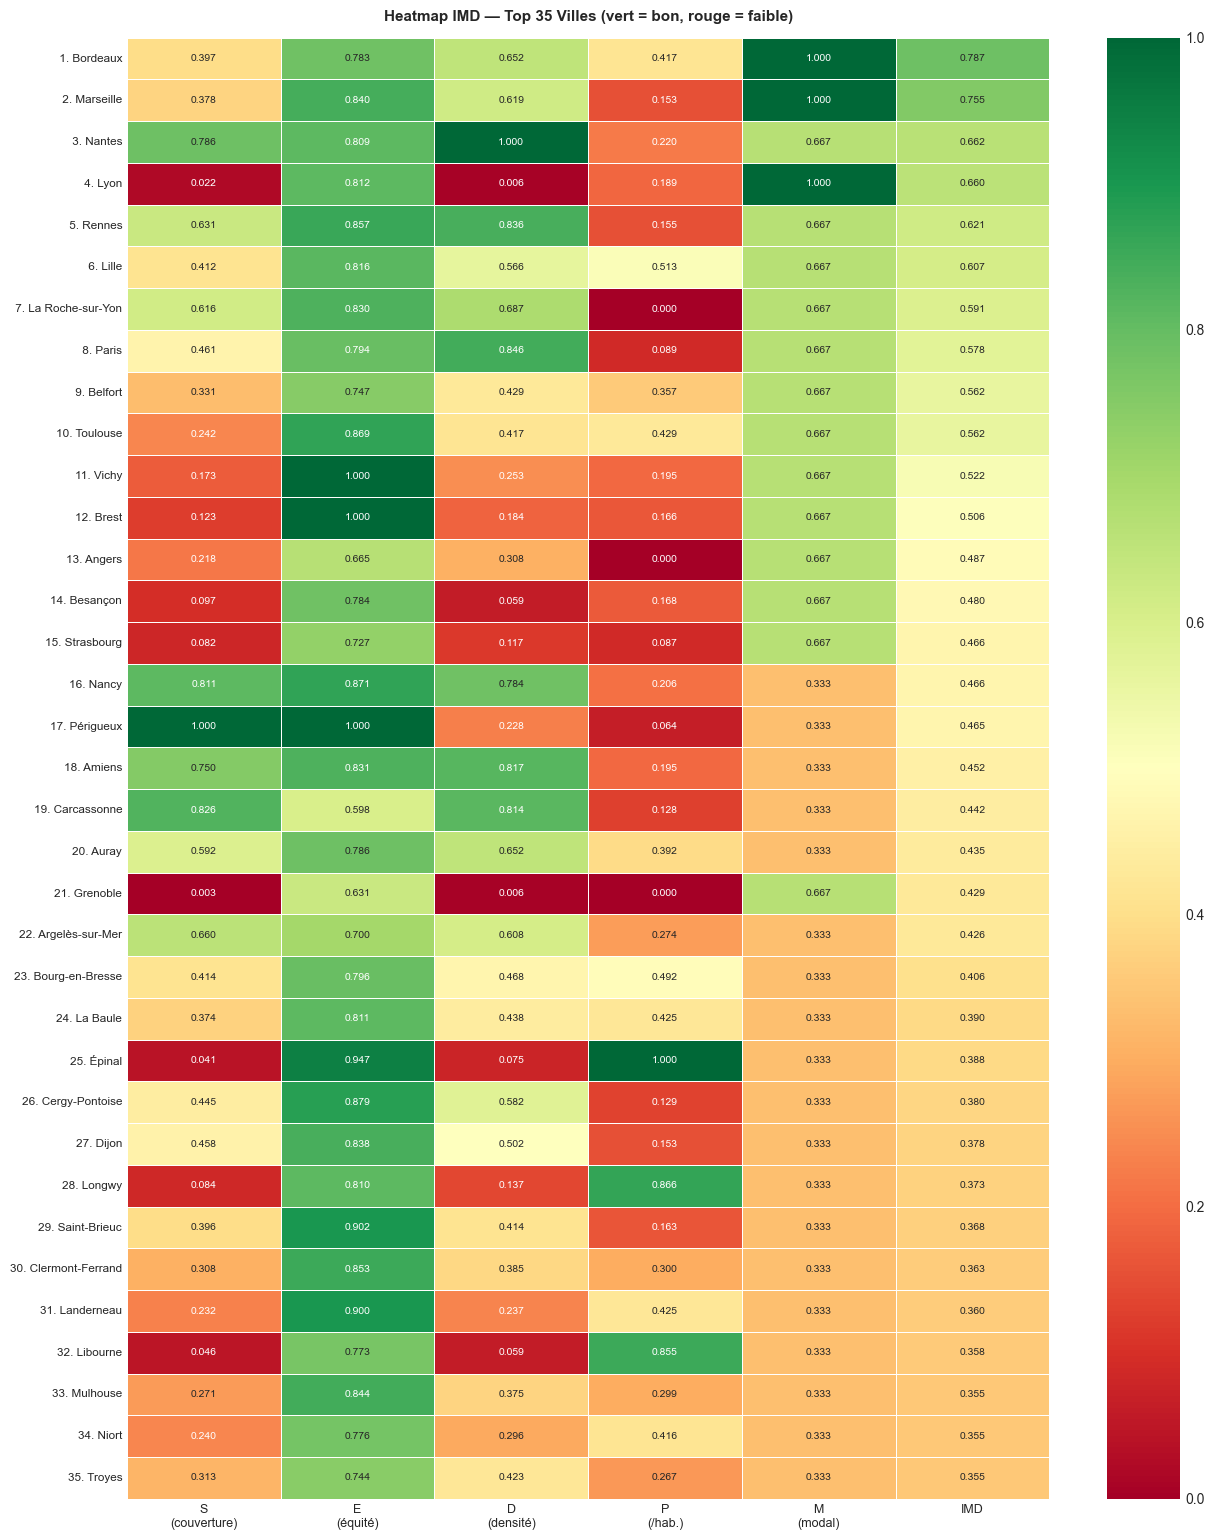

In [8]:
# Heatmap du classement (top 35)
top_n   = min(35, len(df_imd))
df_heat = df_imd.reset_index().head(top_n)

heat_cols    = ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M', 'IMD']
heat_labels  = ['S\n(couverture)', 'E\n(équité)', 'D\n(densité)', 'P\n(/hab.)', 'M\n(modal)', 'IMD']
heat_display = df_heat[heat_cols].fillna(0).round(3)

fig, ax = plt.subplots(figsize=(13, top_n * 0.40 + 1.5))
sns.heatmap(
    heat_display,
    annot=True, fmt='.3f',
    cmap='RdYlGn', vmin=0, vmax=1,
    linewidths=0.4, linecolor='white',
    annot_kws={'size': 7.5},
    xticklabels=heat_labels,
    yticklabels=[f"{r['rang']:2d}. {r['city']}" for _, r in df_heat.iterrows()],
    ax=ax
)
ax.set_title(f'Heatmap IMD — Top {top_n} Villes (vert = bon, rouge = faible)',
             fontsize=11, fontweight='bold', pad=12)
ax.tick_params(axis='y', labelsize=8.5)
ax.tick_params(axis='x', labelsize=9, rotation=0)

plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '04_heatmap_IMD.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Classement et Podium — Les Meilleures Villes

Visualisation du **classement officiel IMD** avec décomposition par composante.

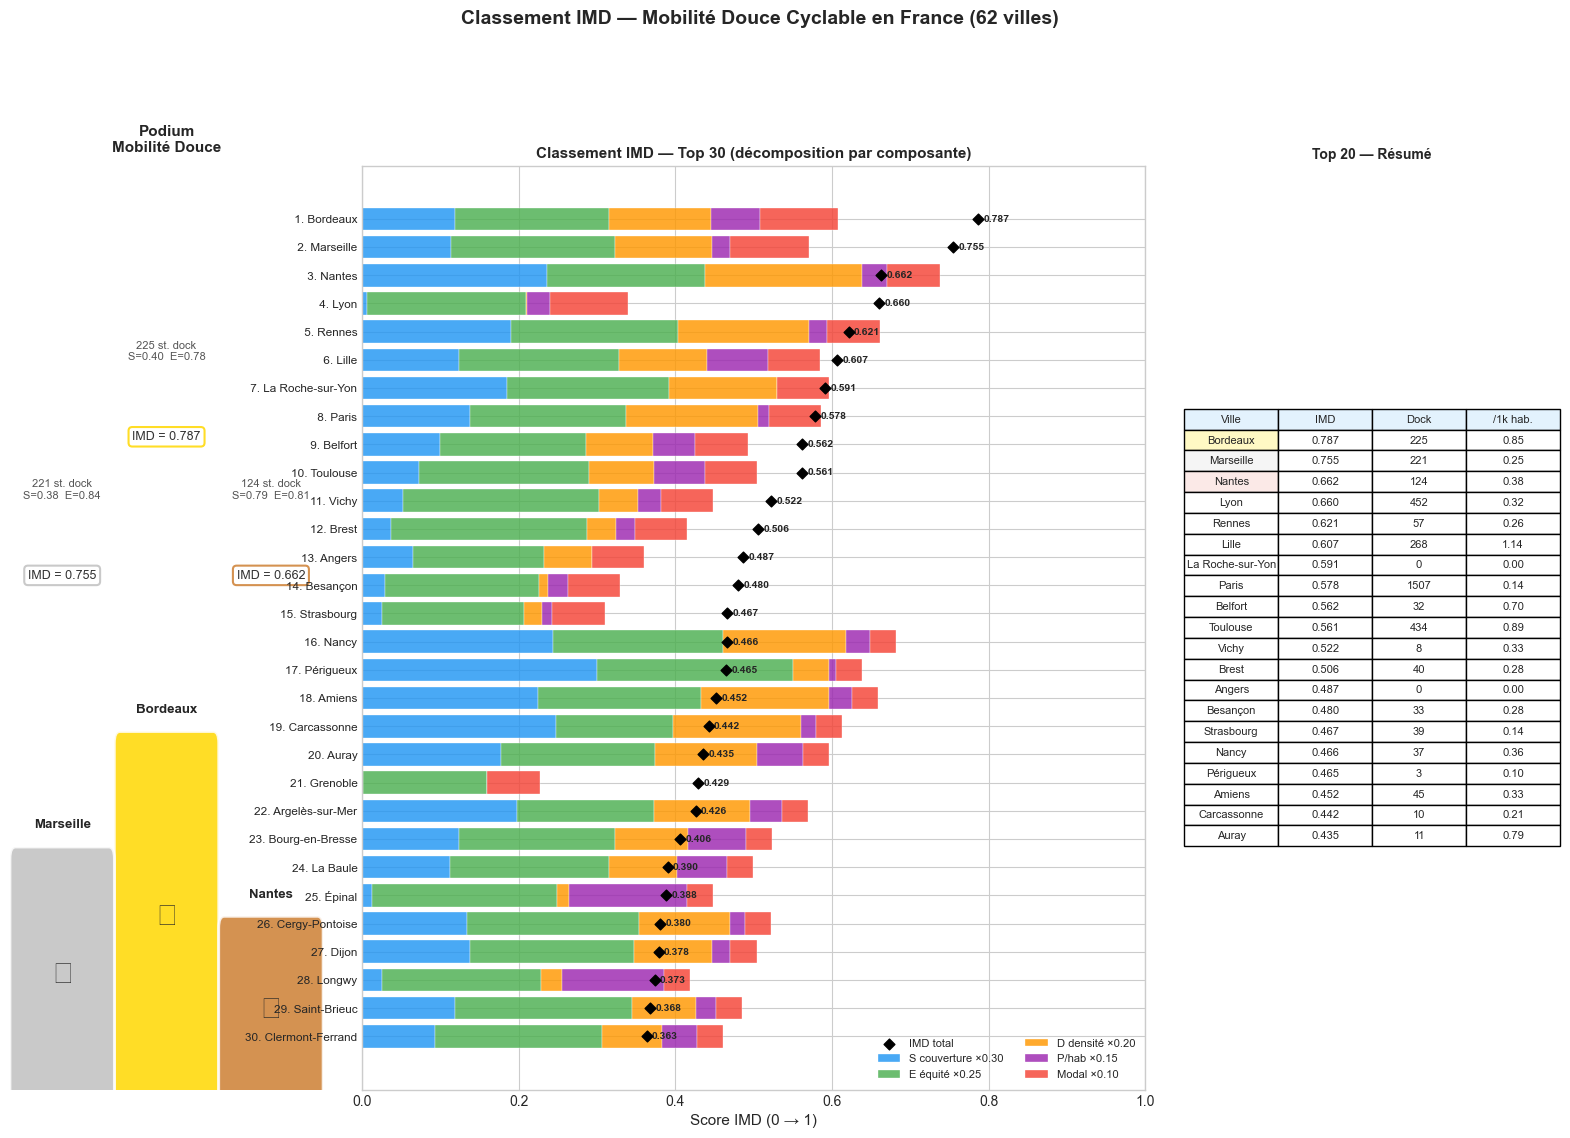

In [9]:
top30 = df_imd.reset_index().head(30)

fig = plt.figure(figsize=(20, 12))
gs  = gridspec.GridSpec(1, 3, width_ratios=[1, 2.5, 1.2], wspace=0.08)

# ── Podium Top 3 ───────────────────────────────────────────────────────────
ax_pod = fig.add_subplot(gs[0])
ax_pod.set_xlim(0, 3)
ax_pod.set_ylim(0, 4)
ax_pod.axis('off')

GOLD, SILVER, BRONZE = '#FFD700', '#C0C0C0', '#CD7F32'
medal_data = [
    (1.5, 2.8, GOLD,   '🥇', top30.iloc[0]),
    (0.5, 2.2, SILVER, '🥈', top30.iloc[1]),
    (2.5, 2.2, BRONZE, '🥉', top30.iloc[2]),
]
for x, y, color, medal, row in medal_data:
    # Podium block
    h = {'🥇': 1.5, '🥈': 1.0, '🥉': 0.7}[medal]
    rect = mpatches.FancyBboxPatch(
        (x - 0.45, 0), 0.9, h,
        boxstyle='round,pad=0.05',
        facecolor=color, alpha=0.85, edgecolor='white', linewidth=2
    )
    ax_pod.add_patch(rect)
    ax_pod.text(x, h/2, medal, ha='center', va='center', fontsize=22)
    ax_pod.text(x, h + 0.12, row['city'], ha='center', va='bottom',
                fontsize=9.5, fontweight='bold', wrap=True)
    ax_pod.text(x, y, f"IMD = {row['IMD']:.3f}", ha='center', va='bottom',
                fontsize=9, color='#333333',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.85,
                          edgecolor=color, linewidth=1.5))
    ax_pod.text(x, y + 0.35,
                f"{row['n_dock']} st. dock\nS={row.get('S_ville', 0):.2f}  E={row.get('E_dock', 0):.2f}",
                ha='center', va='bottom', fontsize=8, color='#555555')

ax_pod.set_title('Podium\nMobilité Douce', fontsize=11, fontweight='bold', pad=10)

# ── Barplot décomposé Top 30 ──────────────────────────────────────────────
ax_bar = fig.add_subplot(gs[1])
y_pos  = np.arange(len(top30))

c_palette = {'C1_S': '#2196F3', 'C2_E': '#4CAF50', 'C3_D': '#FF9800',
             'C4_P': '#9C27B0', 'C5_M': '#F44336'}
c_labels  = {'C1_S': 'S couverture ×0.30', 'C2_E': 'E équité ×0.25',
             'C3_D': 'D densité ×0.20', 'C4_P': 'P/hab ×0.15', 'C5_M': 'Modal ×0.10'}
w_vals    = {'C1_S': 0.30, 'C2_E': 0.25, 'C3_D': 0.20, 'C4_P': 0.15, 'C5_M': 0.10}

left = np.zeros(len(top30))
for comp in ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M']:
    vals = top30[comp].fillna(0).values * w_vals[comp]
    ax_bar.barh(y_pos, vals, left=left, color=c_palette[comp],
                alpha=0.82, label=c_labels[comp], edgecolor='white', linewidth=0.3)
    left += vals

# IMD total
ax_bar.scatter(top30['IMD'], y_pos, marker='D', s=30, color='black',
               zorder=5, label='IMD total')
for i, v in enumerate(top30['IMD']):
    ax_bar.text(v + 0.007, i, f'{v:.3f}', va='center', fontsize=7.5, fontweight='bold')

ax_bar.set_yticks(y_pos)
ax_bar.set_yticklabels([f"{r['rang']:2d}. {r['city']}" for _, r in top30.iterrows()],
                        fontsize=8.5)
ax_bar.set_xlabel('Score IMD (0 → 1)', fontsize=11)
ax_bar.set_xlim(0, 1.0)
ax_bar.set_title('Classement IMD — Top 30 (décomposition par composante)', fontsize=11, fontweight='bold')
ax_bar.legend(fontsize=8, loc='lower right', ncol=2)
ax_bar.invert_yaxis()

# ── Tableau métriques clés ────────────────────────────────────────────────
ax_tab = fig.add_subplot(gs[2])
ax_tab.axis('off')

tbl_data = [
    [r['city'][:18], f"{r['IMD']:.3f}",
     f"{int(r['n_dock'])}",
     f"{r.get('dock_per_1k_hab', float('nan')):.2f}" if not pd.isna(r.get('dock_per_1k_hab')) else '—']
    for _, r in top30.head(20).iterrows()
]
table = ax_tab.table(
    cellText=tbl_data,
    colLabels=['Ville', 'IMD', 'Dock', '/1k hab.'],
    cellLoc='center', loc='center',
    colColours=['#E3F2FD'] * 4
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.25)

# Médailles
for i, medal in enumerate(['🥇', '🥈', '🥉']):
    cell = table[(i + 1, 0)]
    cell.set_facecolor({0: '#FFF9C4', 1: '#F5F5F5', 2: '#FBE9E7'}[i])

ax_tab.set_title('Top 20 — Résumé', fontsize=10, fontweight='bold', pad=5)

plt.suptitle(f'Classement IMD — Mobilité Douce Cyclable en France ({len(df_imd)} villes)',
             fontsize=14, fontweight='bold', y=1.01)
plt.savefig(OUTPUT_NB / 'figures' / '05_classement_podium.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Zones Blanches — Distance à la Station la Plus Proche

Pour chaque grande ville, une **carte de chaleur** montre les zones mal desservies  
(rouge = distance > 500 m = zone blanche).

Villes analysées : ['Paris', 'Lyon', 'Toulouse', 'Lille', 'Bordeaux', 'Marseille']


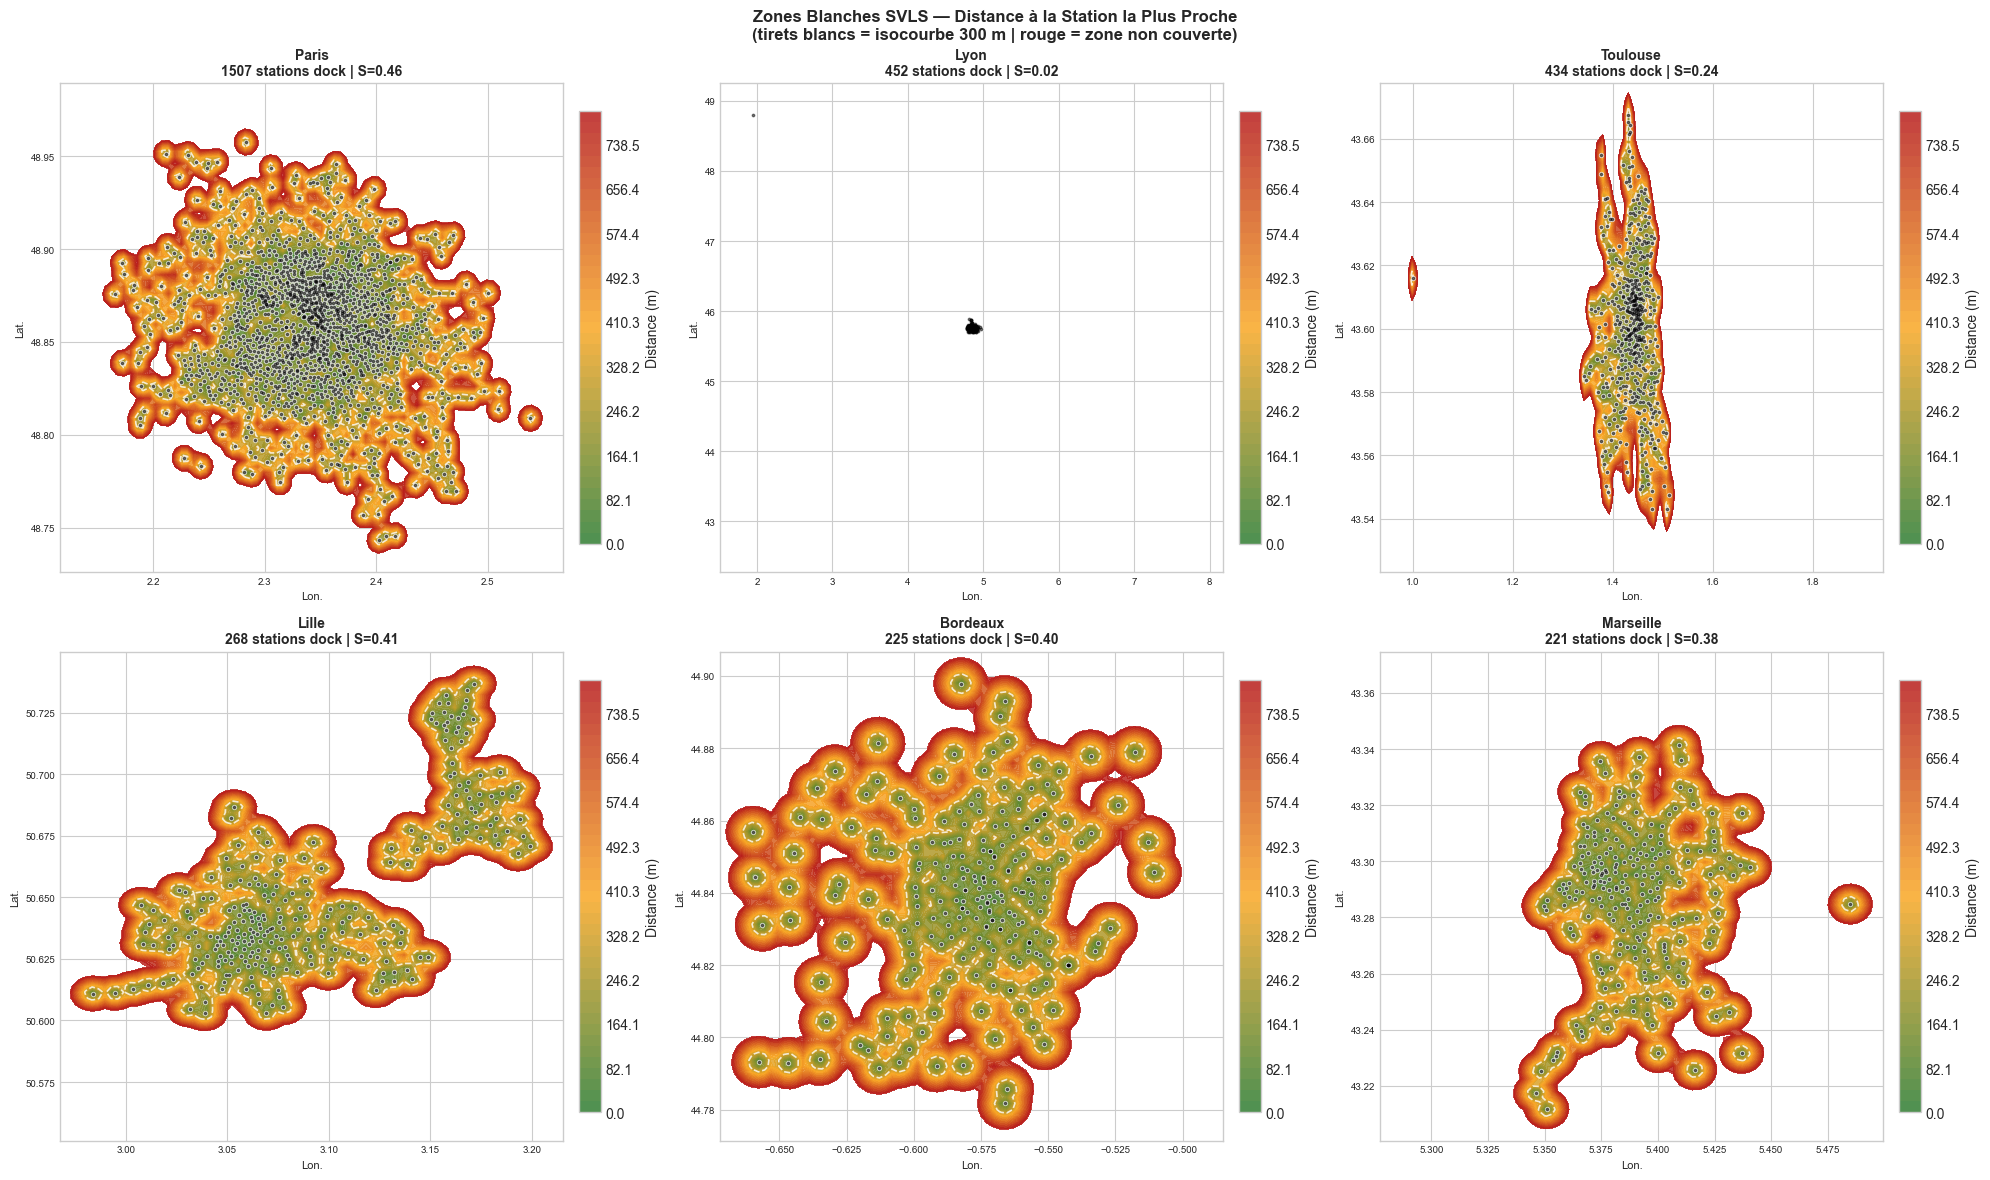

In [10]:
# Top 6 villes par n_dock avec S_ville calculé
cities_gap = (
    df_city[df_city['n_dock'] >= 20]
    .dropna(subset=['S_ville'])
    .nlargest(6, 'n_dock')
    ['city'].tolist()
)
print(f'Villes analysées : {cities_gap}')

def compute_gap_map(lats, lons, grid_size=80):
    """Carte distance à la station la plus proche."""
    lat_c, lon_c = lats.mean(), lons.mean()
    m_lat = 111_132.0
    m_lon = 111_320.0 * np.cos(np.radians(lat_c))
    x = (lons - lon_c) * m_lon
    y = (lats - lat_c) * m_lat
    margin = 0.15
    xr = max(abs(x).max() * (1 + margin), 500)
    yr = max(abs(y).max() * (1 + margin), 500)
    xi = np.linspace(-xr, xr, grid_size)
    yi = np.linspace(-yr, yr, grid_size)
    Xg, Yg = np.meshgrid(xi, yi)
    tree = cKDTree(np.column_stack([x, y]))
    dist, _ = tree.query(np.column_stack([Xg.ravel(), Yg.ravel()]))
    dist_m  = dist.reshape(grid_size, grid_size)
    lon_g   = Xg / m_lon + lon_c
    lat_g   = Yg / m_lat + lat_c
    return lon_g, lat_g, dist_m


fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for ax, city in zip(axes.flat, cities_gap):
    grp = df_dock_st[df_dock_st['city_n'] == city]
    if len(grp) < 3:
        ax.set_title(f'{city} — données insuffisantes')
        ax.axis('off')
        continue

    lats = grp['lat'].values
    lons = grp['lon'].values
    lon_g, lat_g, dist_m = compute_gap_map(lats, lons)

    # Colormap : vert (≤ 200m), jaune (300m), rouge (≥ 600m)
    from matplotlib.colors import LinearSegmentedColormap
    cmap_gap = LinearSegmentedColormap.from_list(
        'gap', ['#2E7D32', '#F9A825', '#B71C1C'], N=256
    )
    cf = ax.contourf(lon_g, lat_g, dist_m,
                     levels=np.linspace(0, 800, 40),
                     cmap=cmap_gap, alpha=0.85)
    plt.colorbar(cf, ax=ax, label='Distance (m)', fraction=0.04, pad=0.03)

    # Stations
    ax.scatter(lons, lats, s=8, c='white', alpha=0.7, zorder=3)
    ax.scatter(lons, lats, s=3, c='black', alpha=0.5, zorder=4)

    # Cercles de référence (300m)
    ax.contour(lon_g, lat_g, dist_m, levels=[300], colors=['white'],
               linewidths=1.2, alpha=0.8, linestyles='--')

    s_val = df_city[df_city['city'] == city]['S_ville'].values
    s_str = f'{s_val[0]:.2f}' if len(s_val) > 0 and not np.isnan(s_val[0]) else '?'
    n_st  = df_city[df_city['city'] == city]['n_dock'].values[0] if len(df_city[df_city['city'] == city]) > 0 else len(grp)

    ax.set_title(f'{city}\n{int(n_st)} stations dock | S={s_str}',
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Lon.', fontsize=8)
    ax.set_ylabel('Lat.', fontsize=8)
    ax.tick_params(labelsize=7)

plt.suptitle('Zones Blanches SVLS — Distance à la Station la Plus Proche\n'
             '(tirets blancs = isocourbe 300 m | rouge = zone non couverte)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '06_zones_blanches.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Sur/Sous-Performeurs — Villes qui Surprennent

Comparaison de l'IMD observé avec l'IMD attendu en fonction de la taille de la ville :  
les **sur-performeurs** dépassent les attentes, les **sous-performeurs** sont en retard.

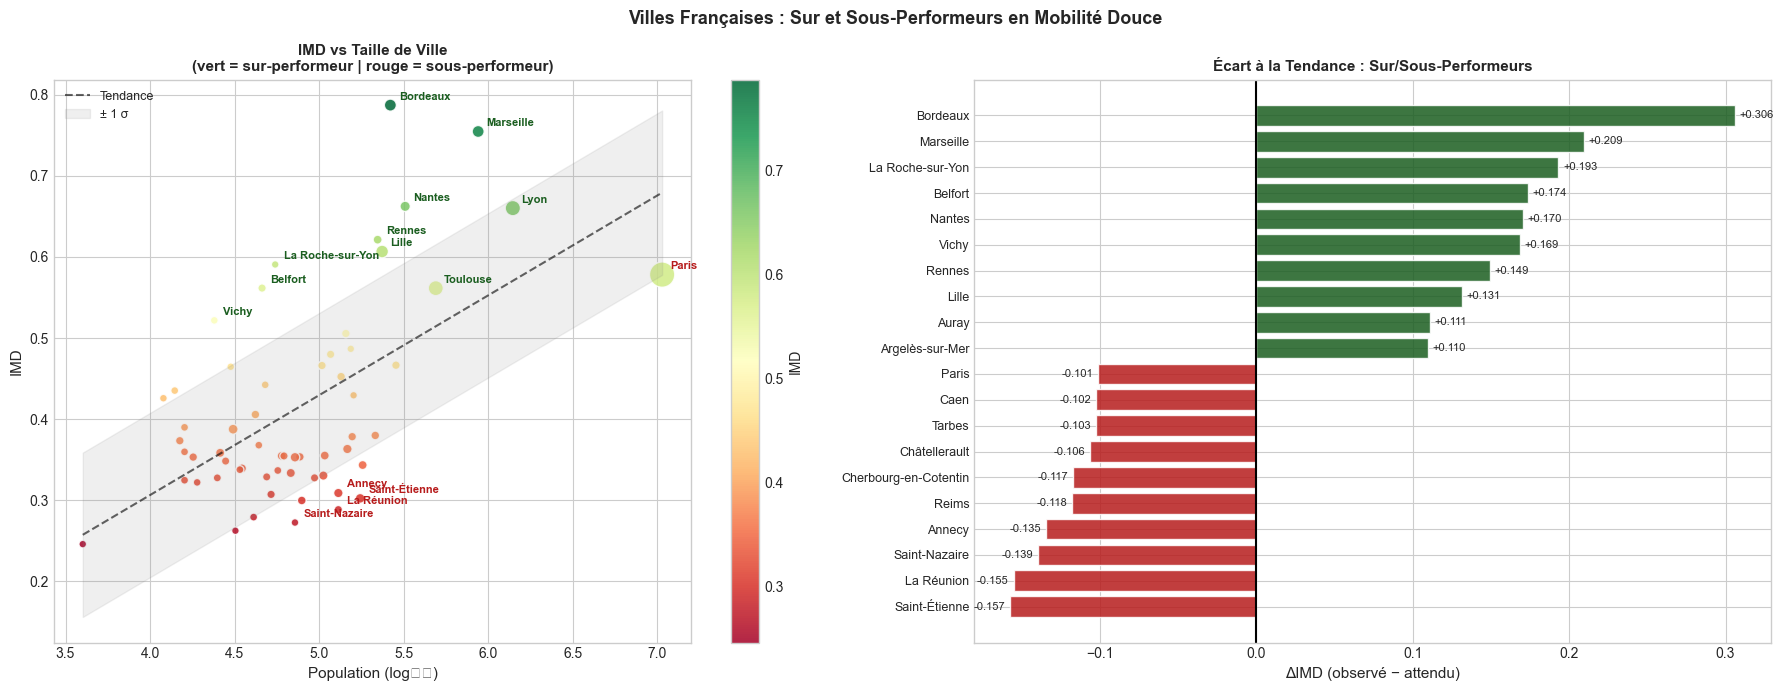

Top 5 sur-performeurs :
            city    IMD  IMD_expected  delta_IMD  n_dock
        Bordeaux 0.7872      0.481376   0.305824     225
       Marseille 0.7547      0.545319   0.209381     221
La Roche-sur-Yon 0.5907      0.397511   0.193189       0
         Belfort 0.5616      0.387957   0.173643      32
          Nantes 0.6624      0.492160   0.170240     124

Top 5 sous-performeurs :
         city    IMD  IMD_expected  delta_IMD  n_dock
Saint-Étienne 0.3023      0.459393  -0.157093      97
   La Réunion 0.2884      0.443501  -0.155101      31
Saint-Nazaire 0.2725      0.411910  -0.139410       5
       Annecy 0.3089      0.443501  -0.134601      80
        Reims 0.3434      0.461196  -0.117796      63


In [11]:
# df_imd est déjà un sous-ensemble de df_city (via df_city.copy() en cell-13)
# → il contient déjà n_total, n_ff, population ; pas besoin de re-merger
df_sp = df_imd.reset_index().copy()
df_sp_pop = df_sp.dropna(subset=['population']).copy()
df_sp_pop['log_pop'] = np.log10(df_sp_pop['population'])

# Droite de tendance IMD = f(log_pop)
z = np.polyfit(df_sp_pop['log_pop'], df_sp_pop['IMD'], 1)
p_trend = np.poly1d(z)
df_sp_pop['IMD_expected'] = p_trend(df_sp_pop['log_pop'])
df_sp_pop['delta_IMD'] = df_sp_pop['IMD'] - df_sp_pop['IMD_expected']

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Scatter IMD vs log(pop) ---
ax = axes[0]
norm_imd = plt.Normalize(df_sp_pop['IMD'].min(), df_sp_pop['IMD'].max())
sc = ax.scatter(
    df_sp_pop['log_pop'], df_sp_pop['IMD'],
    c=df_sp_pop['IMD'], cmap=CMAP_IMD,
    s=df_sp_pop['n_dock'] / 5 + 30,
    alpha=0.85, edgecolors='white'
)
plt.colorbar(sc, ax=ax, label='IMD')
x_range = np.linspace(df_sp_pop['log_pop'].min(), df_sp_pop['log_pop'].max(), 100)
ax.plot(x_range, p_trend(x_range), 'k--', lw=1.5, alpha=0.6, label='Tendance')

# Zone de sur/sous-performance
std_delta = df_sp_pop['delta_IMD'].std()
ax.fill_between(x_range, p_trend(x_range) - std_delta, p_trend(x_range) + std_delta,
                alpha=0.12, color='gray', label='± 1 σ')

# Annoter les extrêmes
for _, row in df_sp_pop.iterrows():
    if abs(row['delta_IMD']) > 1.2 * std_delta or row['n_dock'] > 150:
        color = '#1B5E20' if row['delta_IMD'] > 0 else '#B71C1C'
        ax.annotate(
            row['city'],
            (row['log_pop'], row['IMD']),
            textcoords='offset points', xytext=(6, 4),
            fontsize=8, color=color, fontweight='bold'
        )

ax.set_xlabel('Population (log₁₀)', fontsize=11)
ax.set_ylabel('IMD', fontsize=11)
ax.set_title('IMD vs Taille de Ville\n(vert = sur-performeur | rouge = sous-performeur)',
             fontsize=11, fontweight='bold')
ax.legend(fontsize=9)

# --- Delta IMD barplot ---
ax2 = axes[1]
df_delta = df_sp_pop.sort_values('delta_IMD', ascending=False)
top_n_delta = min(20, len(df_delta))
df_show = pd.concat([df_delta.head(10), df_delta.tail(10)]).drop_duplicates()
df_show = df_show.sort_values('delta_IMD', ascending=True)

cols_delta = ['#1B5E20' if v > 0 else '#B71C1C' for v in df_show['delta_IMD']]
ax2.barh(range(len(df_show)), df_show['delta_IMD'], color=cols_delta, alpha=0.85, edgecolor='white')
ax2.axvline(0, color='black', lw=1.5)
ax2.set_yticks(range(len(df_show)))
ax2.set_yticklabels(df_show['city'], fontsize=9)
ax2.set_xlabel('ΔIMD (observé − attendu)', fontsize=11)
ax2.set_title('Écart à la Tendance : Sur/Sous-Performeurs',
              fontsize=11, fontweight='bold')
for i, v in enumerate(df_show['delta_IMD']):
    ax2.text(v + (0.003 if v > 0 else -0.003), i, f'{v:+.3f}',
             va='center', ha='left' if v > 0 else 'right', fontsize=8)

plt.suptitle('Villes Françaises : Sur et Sous-Performeurs en Mobilité Douce',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '07_sur_sous_performeurs.png', dpi=150, bbox_inches='tight')
plt.show()

print('Top 5 sur-performeurs :')
print(df_sp_pop.nlargest(5, 'delta_IMD')[['city', 'IMD', 'IMD_expected', 'delta_IMD', 'n_dock']].to_string(index=False))
print('\nTop 5 sous-performeurs :')
print(df_sp_pop.nsmallest(5, 'delta_IMD')[['city', 'IMD', 'IMD_expected', 'delta_IMD', 'n_dock']].to_string(index=False))

## 10. Carte Nationale — IMD par Ville

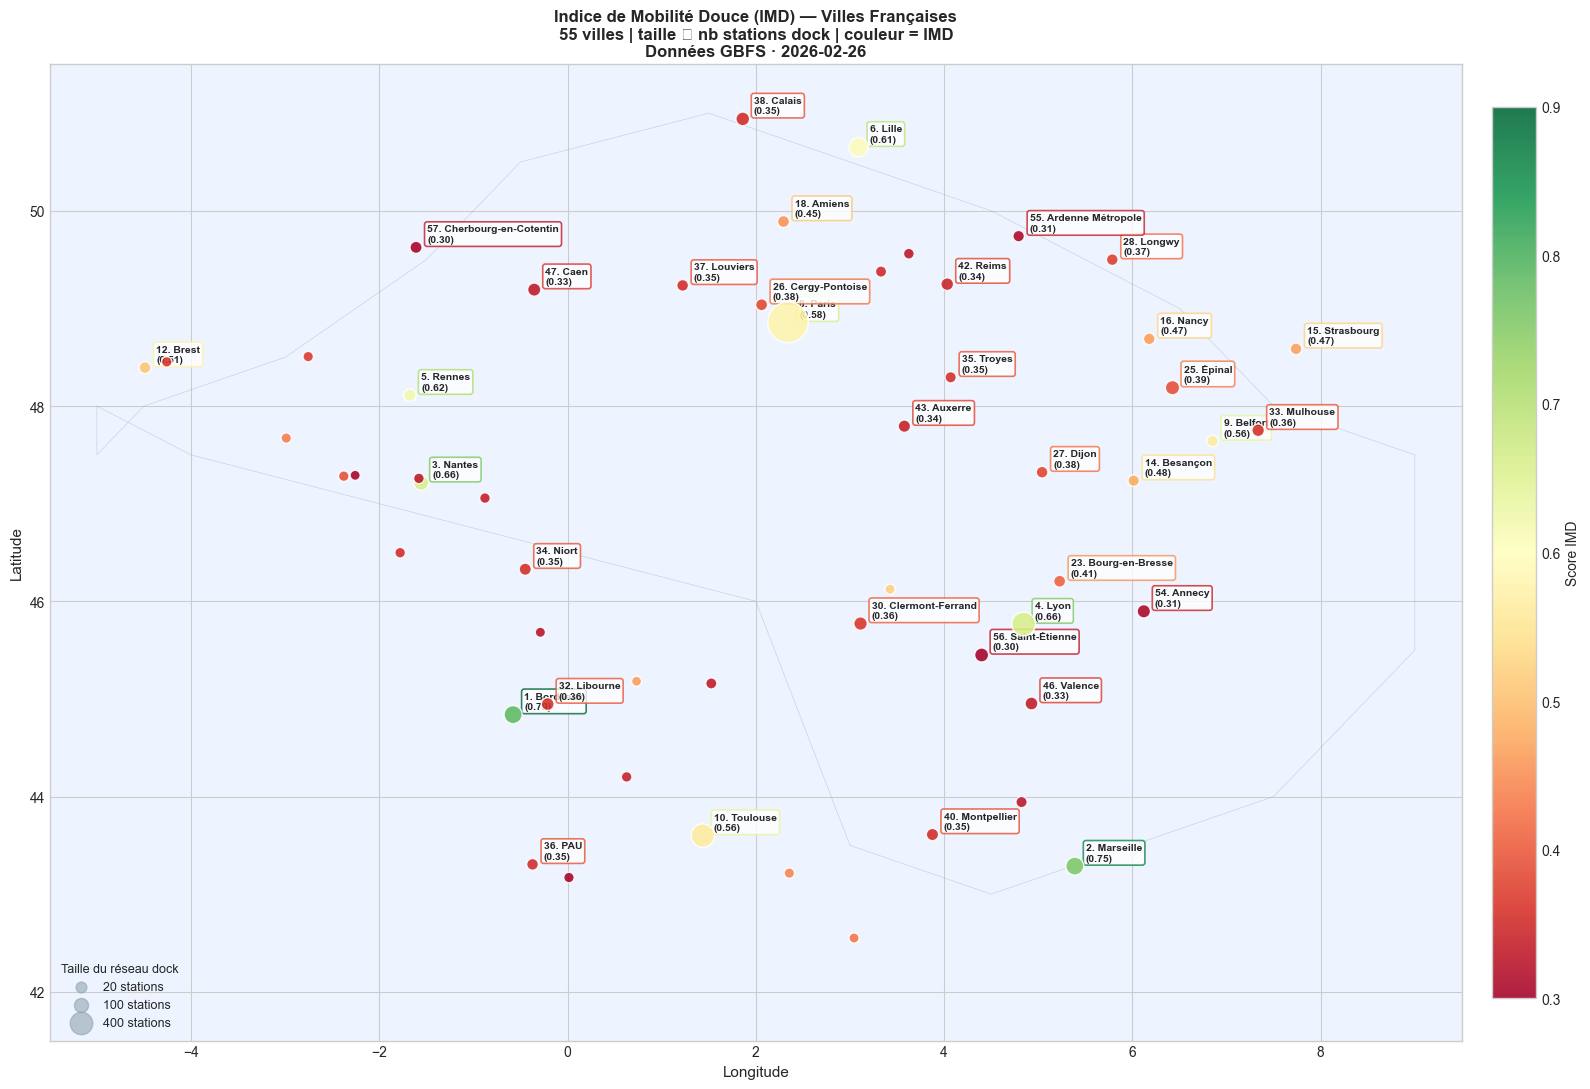

In [12]:
# Centroïdes des villes (depuis les stations dock)
centroids = (
    df_dock_st.groupby('city_n')[['lat', 'lon']]
    .mean()
    .reset_index()
    .rename(columns={'city_n': 'city', 'lat': 'lat_c', 'lon': 'lon_c'})
)
df_map = df_imd.reset_index().merge(centroids, on='city', how='left')
df_map = df_map.merge(df_city[['city', 'n_ff', 'n_semi']], on='city', how='left')

# Filtrage France métropolitaine
df_metro_map = df_map[
    (df_map['lat_c'] > 41.5) & (df_map['lat_c'] < 51.5) &
    (df_map['lon_c'] > -5.5) & (df_map['lon_c'] < 9.5)
].copy()

fig, ax = plt.subplots(figsize=(16, 11))

# Fond de carte stylisé
ax.set_facecolor('#EEF4FF')
ax.add_patch(plt.Rectangle((-5.5, 41.5), 15, 10, facecolor='#EEF4FF', zorder=0))

# Contour France (approximatif)
france_outline_x = [-5.0, -4.0, -2.0,  0.0,  2.0,  3.0,  4.5,  6.0,  7.5,  9.0,  9.0,  7.5,  6.5,  5.5,  4.5,  3.0,  1.5, -0.5, -1.5, -3.0, -4.5, -5.0, -5.0]
france_outline_y = [48.0, 47.5, 47.0, 46.5, 46.0, 43.5, 43.0, 43.5, 44.0, 45.5, 47.5, 48.0, 49.0, 49.5, 50.0, 50.5, 51.0, 50.5, 49.5, 48.5, 48.0, 47.5, 48.0]
ax.plot(france_outline_x, france_outline_y, color='#90A4AE', lw=0.5, alpha=0.4)

# Bulles IMD
norm_imd = plt.Normalize(df_metro_map['IMD'].min(), df_metro_map['IMD'].max())
sizes = (df_metro_map['n_dock'] / df_metro_map['n_dock'].max() * 800 + 50).clip(50, 900)

sc = ax.scatter(
    df_metro_map['lon_c'], df_metro_map['lat_c'],
    c=df_metro_map['IMD'], cmap=CMAP_IMD,
    vmin=0.3, vmax=0.9,
    s=sizes, alpha=0.88,
    edgecolors='white', linewidths=1.0, zorder=4
)
cb = plt.colorbar(sc, ax=ax, label='Score IMD', fraction=0.03, pad=0.02)
cb.set_ticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Annotations
for _, row in df_metro_map.iterrows():
    if row['n_dock'] >= 30 or row['IMD'] >= df_metro_map['IMD'].quantile(0.85):
        rang = int(row['rang'])
        ax.annotate(
            f"{rang}. {row['city']}\n({row['IMD']:.2f})",
            (row['lon_c'], row['lat_c']),
            textcoords='offset points', xytext=(8, 4),
            fontsize=7.5, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.80,
                      edgecolor=CMAP_IMD(norm_imd(row['IMD'])), linewidth=1.2)
        )

# Légende taille
for n_ref in [20, 100, 400]:
    s_ref = n_ref / df_metro_map['n_dock'].max() * 800 + 50
    ax.scatter([], [], s=s_ref, color='#90A4AE', alpha=0.6,
               label=f'{n_ref} stations')
ax.legend(title='Taille du réseau dock', fontsize=9, title_fontsize=9, loc='lower left')

ax.set_xlim(-5.5, 9.5)
ax.set_ylim(41.5, 51.5)
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)
ax.set_title(
    f'Indice de Mobilité Douce (IMD) — Villes Françaises\n'
    f'{len(df_metro_map)} villes | taille ∝ nb stations dock | couleur = IMD\n'
    f'Données GBFS · {datetime.now().strftime("%Y-%m-%d")}',
    fontsize=12, fontweight='bold'
)

plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '08_carte_IMD_nationale.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Analyse Typologique — Profils de Villes

Quelles villes ont un profil similaire ? Comparaison radar multi-axes.

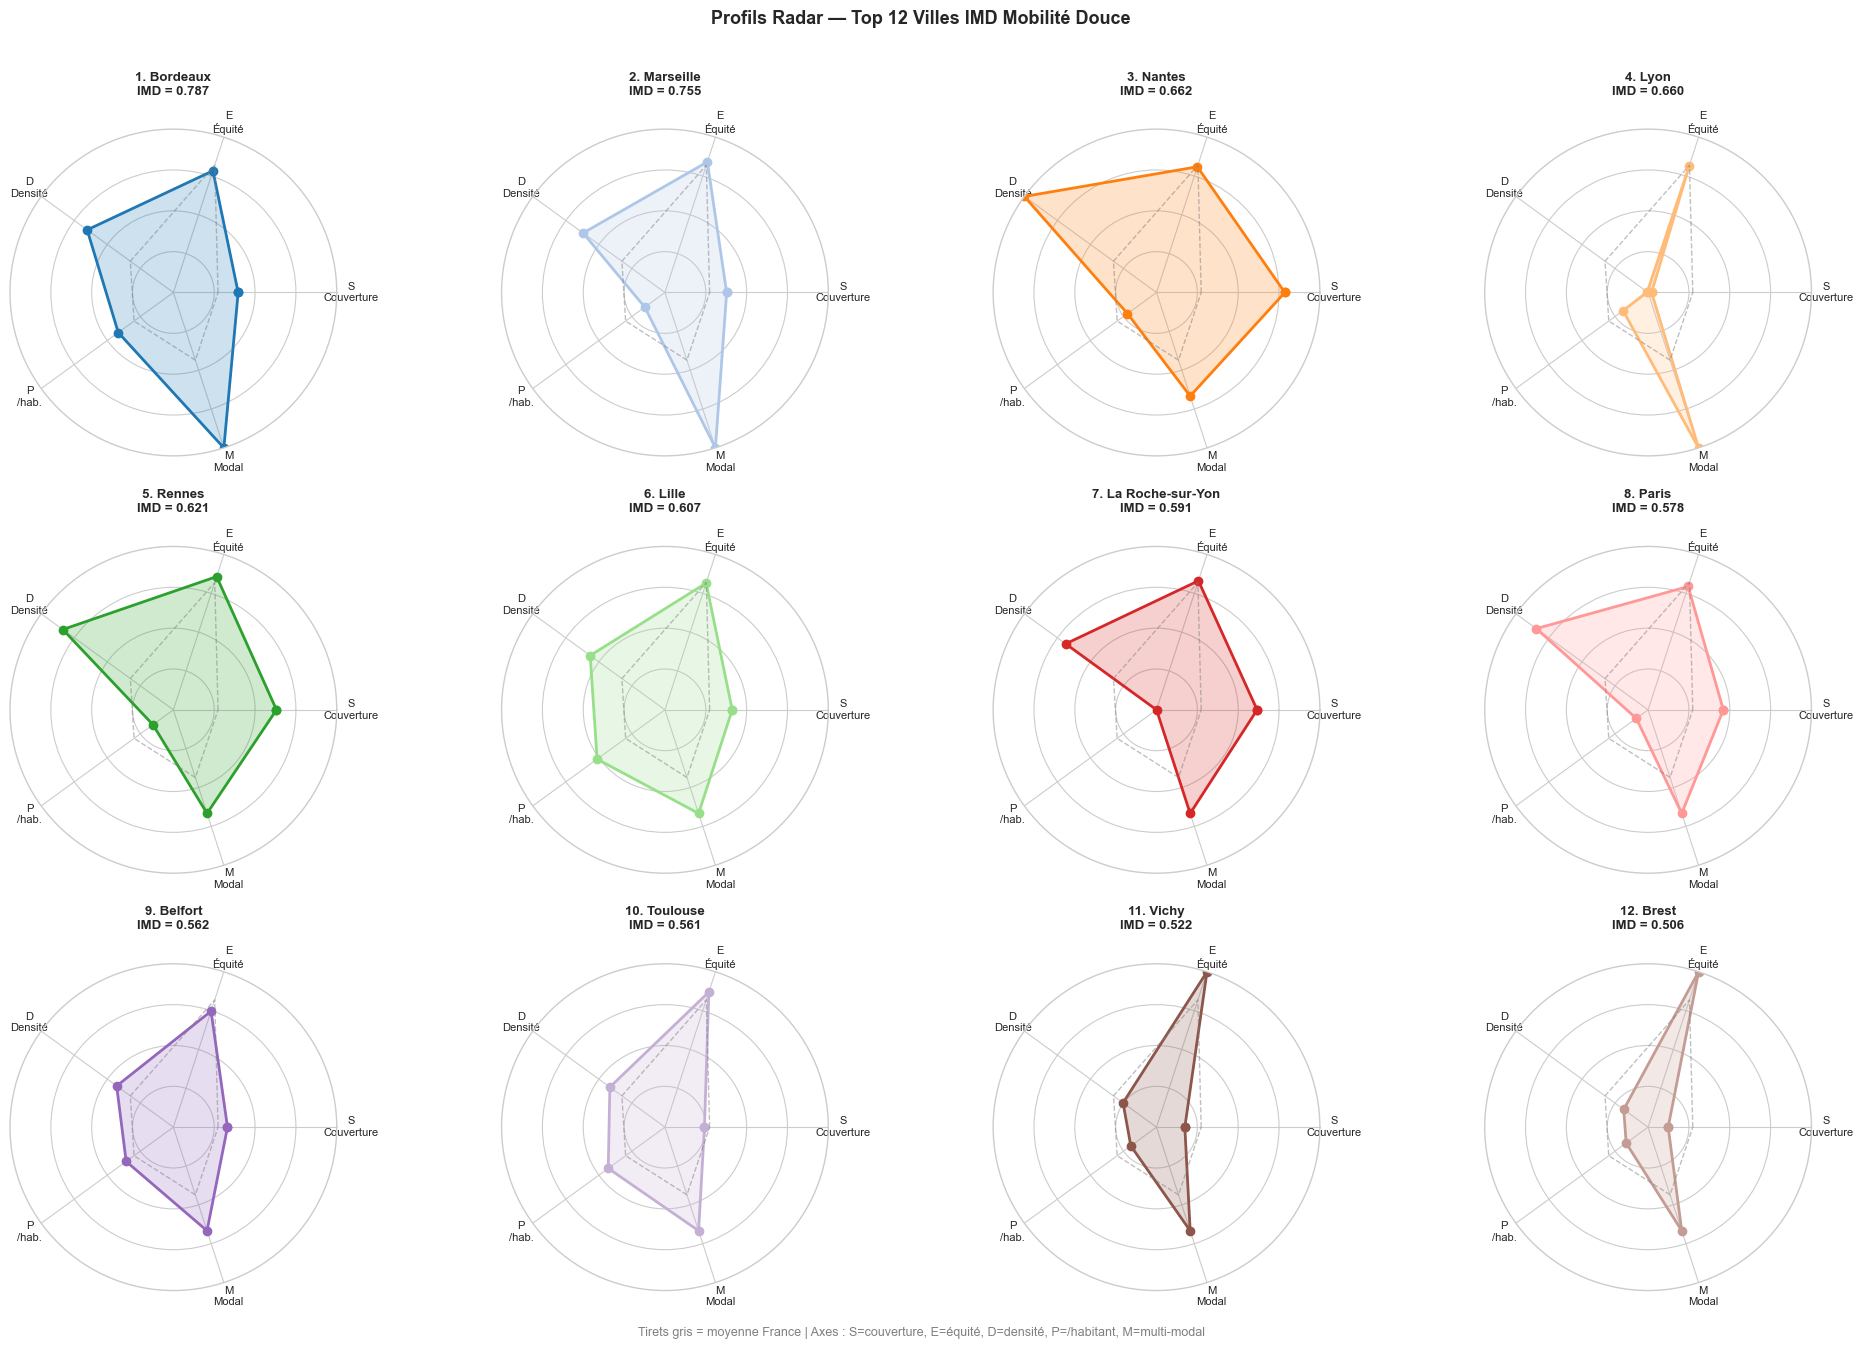

In [13]:
# Radar des 12 premières villes du classement
top12 = df_imd.reset_index().head(12)

axes_radar = ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M']
axes_lbl   = ['S\nCouverture', 'E\nÉquité', 'D\nDensité', 'P\n/hab.', 'M\nModal']
n_ax = len(axes_radar)
angles = np.linspace(0, 2 * np.pi, n_ax, endpoint=False).tolist() + [0]

fig, axes = plt.subplots(3, 4, figsize=(20, 13), subplot_kw=dict(polar=True))
palette = plt.cm.tab20.colors

for i, (ax, (_, row)) in enumerate(zip(axes.flat, top12.iterrows())):
    vals = [row.get(c, 0) or 0 for c in axes_radar]
    vals += vals[:1]
    color = palette[i % len(palette)]

    ax.plot(angles, vals, 'o-', color=color, lw=2)
    ax.fill(angles, vals, color=color, alpha=0.22)

    # Référence (moyenne France)
    avg_vals = [df_imd[c].mean() for c in axes_radar] + [df_imd[axes_radar[0]].mean()]
    ax.plot(angles, avg_vals, '--', color='gray', lw=1, alpha=0.5)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(axes_lbl, fontsize=8)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(['', '', ''], fontsize=0)
    ax.set_title(
        f"{row['rang']}. {row['city']}\nIMD = {row['IMD']:.3f}",
        fontsize=9.5, fontweight='bold', pad=12
    )

# Légende globale
fig.text(0.5, -0.01,
         'Tirets gris = moyenne France | Axes : S=couverture, E=équité, D=densité, P=/habitant, M=multi-modal',
         ha='center', fontsize=9, color='gray')

plt.suptitle('Profils Radar — Top 12 Villes IMD Mobilité Douce',
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '09_radar_top12.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Gap Analysis — Combien de Stations Manquent ?

Estimation des stations supplémentaires nécessaires pour que chaque ville atteigne **IMD = 0.70**.

Villes sous IMD = 0.7 (avec gap > 0.05) : 58
                 city    IMD  gap_IMD    bottleneck  stations_needed
     Montreuil-Bellay 0.2459   0.4541  Offre/hab. P                0
        Châtellerault 0.2624   0.4376  Offre/hab. P                0
        Saint-Nazaire 0.2725   0.4275     Densité D             3510
               Tarbes 0.2792   0.4208     Densité D             1310
           La Réunion 0.2884   0.4116     Densité D             1482
Cherbourg-en-Cotentin 0.2997   0.4003     Densité D             3378
        Saint-Étienne 0.3023   0.3977  Couverture S             7616
    Ardenne Métropole 0.3072   0.3928     Densité D             3506
               Annecy 0.3089   0.3911  Couverture S            11533
                Royan 0.3220   0.3780 Multi-modal M              227
       Pointe-à-Pitre 0.3247   0.3753     Densité D              675
              Avignon 0.3276   0.3724  Offre/hab. P              278
                 Laon 0.3276   0.3724 Multi-modal M       

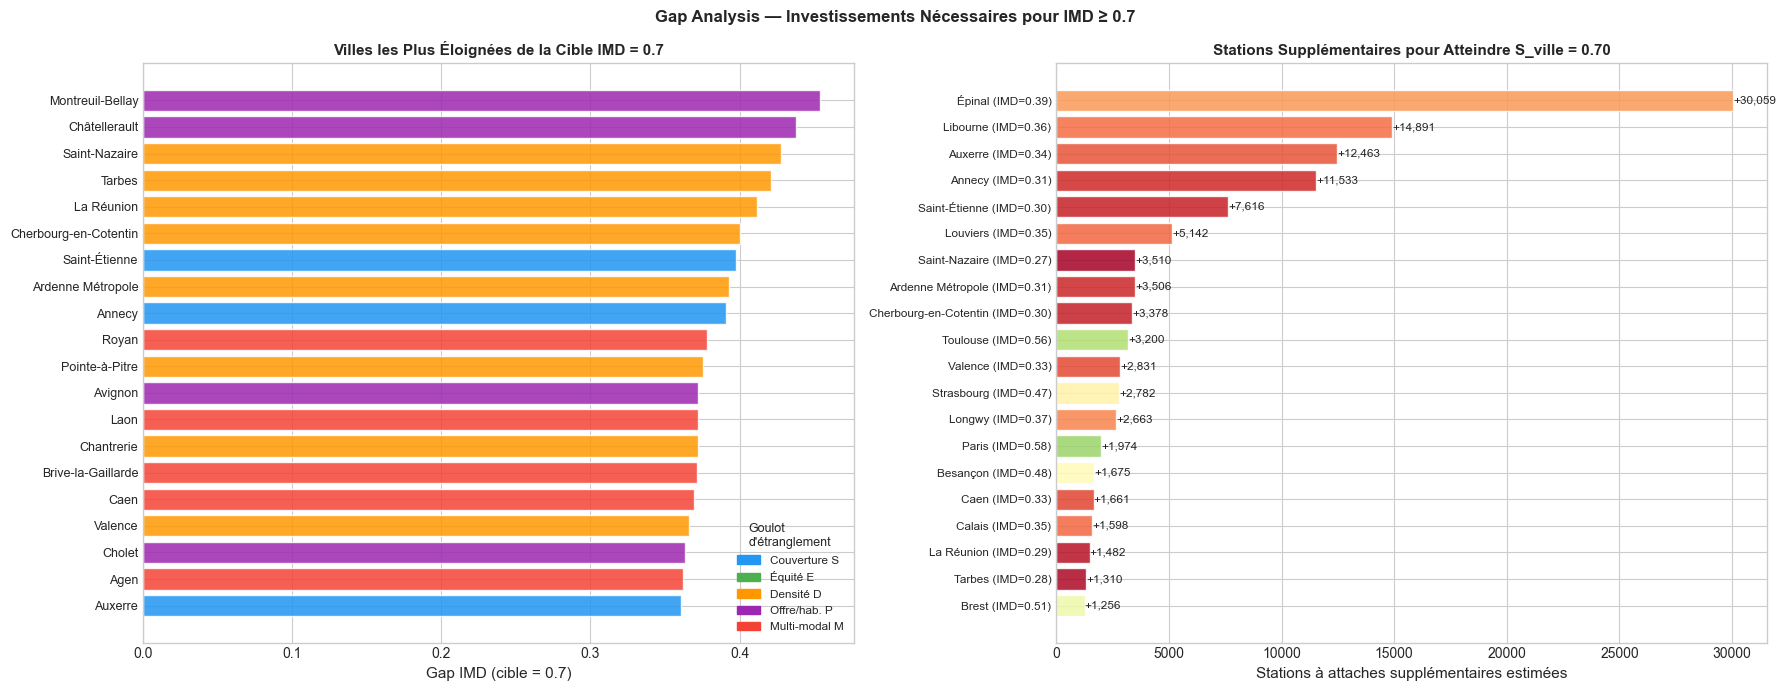

Gap analysis exportée.


In [14]:
TARGET_IMD = 0.70

# Pour chaque ville sous la cible, estimer le levier principal
df_gap = df_imd.reset_index().copy()
df_gap['gap_IMD'] = (TARGET_IMD - df_gap['IMD']).clip(lower=0)

def identify_bottleneck(row):
    """Quelle composante limite le plus l'IMD ?"""
    weighted = {
        'Couverture S': row['C1_S'] * 0.30,
        'Équité E':     row['C2_E'] * 0.25,
        'Densité D':    row['C3_D'] * 0.20,
        'Offre/hab. P': (row['C4_P'] or 0) * 0.15,
        'Multi-modal M':row['C5_M'] * 0.10,
    }
    return min(weighted, key=weighted.get)

def est_stations_needed(row, target_s=0.70):
    """Approximation stations nécessaires pour améliorer la couverture."""
    current_s = row.get('S_ville') or 0
    if current_s >= target_s or pd.isna(current_s):
        return 0
    n_current = row['n_dock']
    # S ≈ k × sqrt(n) → n_needed = n_current × (target_s / current_s)²
    if current_s < 0.01:
        return n_current * 4
    ratio = (target_s / current_s) ** 2
    return max(0, round(n_current * (ratio - 1)))

df_gap['bottleneck']     = df_gap.apply(identify_bottleneck, axis=1)
df_gap['stations_needed']= df_gap.apply(lambda r: est_stations_needed(r) if r['gap_IMD'] > 0 else 0, axis=1)

df_below = df_gap[df_gap['gap_IMD'] > 0.05].sort_values('gap_IMD', ascending=False)

print(f'Villes sous IMD = {TARGET_IMD} (avec gap > 0.05) : {len(df_below)}')
print(df_below[['city', 'IMD', 'gap_IMD', 'bottleneck', 'stations_needed']]
      .head(20).to_string(index=False))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Barplot gap IMD ---
ax = axes[0]
top_gap = df_below.head(20)
btl_colors = {
    'Couverture S': '#2196F3',
    'Équité E':     '#4CAF50',
    'Densité D':    '#FF9800',
    'Offre/hab. P': '#9C27B0',
    'Multi-modal M':'#F44336',
}
bar_c = [btl_colors.get(b, 'gray') for b in top_gap['bottleneck']]
ax.barh(range(len(top_gap)), top_gap['gap_IMD'], color=bar_c, alpha=0.85, edgecolor='white')
ax.set_yticks(range(len(top_gap)))
ax.set_yticklabels(top_gap['city'], fontsize=9)
ax.set_xlabel(f'Gap IMD (cible = {TARGET_IMD})', fontsize=11)
ax.set_title(f'Villes les Plus Éloignées de la Cible IMD = {TARGET_IMD}',
             fontsize=11, fontweight='bold')
ax.invert_yaxis()

# Légende goulot
legend_patches = [mpatches.Patch(color=c, label=l) for l, c in btl_colors.items()]
ax.legend(handles=legend_patches, title='Goulot\nd\'étranglement', fontsize=8.5, title_fontsize=9,
          loc='lower right')

# --- Stations nécessaires ---
ax2 = axes[1]
df_need = df_below[df_below['stations_needed'] > 0].nlargest(20, 'stations_needed')
norm_gap2 = plt.Normalize(0, df_need['gap_IMD'].max())
cols2 = [CMAP_IMD(1 - norm_gap2(v)) for v in df_need['gap_IMD']]

ax2.barh(range(len(df_need)), df_need['stations_needed'], color=cols2, alpha=0.85, edgecolor='white')
ax2.set_yticks(range(len(df_need)))
ax2.set_yticklabels([f"{r['city']} (IMD={r['IMD']:.2f})" for _, r in df_need.iterrows()], fontsize=8.5)
ax2.set_xlabel('Stations à attaches supplémentaires estimées', fontsize=11)
ax2.set_title(f'Stations Supplémentaires pour Atteindre S_ville = 0.70',
              fontsize=11, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(df_need['stations_needed']):
    ax2.text(v + 1, i, f'+{v:,}', va='center', fontsize=8.5)

plt.suptitle(f'Gap Analysis — Investissements Nécessaires pour IMD ≥ {TARGET_IMD}',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '10_gap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Export gap analysis
df_gap[['city', 'IMD', 'gap_IMD', 'bottleneck', 'stations_needed',
        'C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M']].to_csv(
    OUTPUT_NB / 'tables_csv' / 'gap_analysis.csv', index=False
)
print('Gap analysis exportée.')

## 13. Synthèse Nationale

In [15]:
# ── Résumé final ────────────────────────────────────────────────────────────
print('=' * 65)
print('  CLASSEMENT MOBILITÉ DOUCE FRANCE — IMD')
print('=' * 65)
print(f'  Date                   : {datetime.now().strftime("%Y-%m-%d %H:%M")}')
print(f'  Villes classées        : {len(df_imd)}')
print(f'  IMD moyen France       : {df_imd["IMD"].mean():.4f}')
print(f'  IMD médian             : {df_imd["IMD"].median():.4f}')
print(f'  Villes IMD ≥ 0.70      : {(df_imd["IMD"] >= 0.70).sum()}')
print(f'  Villes IMD < 0.50      : {(df_imd["IMD"] < 0.50).sum()}')
print()
print('  PODIUM :')
for i, (_, row) in enumerate(df_imd.reset_index().head(3).iterrows(), 1):
    medal = ['🥇', '🥈', '🥉'][i-1]
    print(f'    {medal} {row["city"]:25s}  '
          f'IMD={row["IMD"]:.3f} | S={row["S_ville"]:.3f} | E={row["E_dock"]:.3f} | '
          f'{int(row["n_dock"])} stations dock')
print()
print('  BOTTOM 3 :')
for i, (_, row) in enumerate(df_imd.reset_index().tail(3).iloc[::-1].iterrows(), 1):
    print(f'    {i}. {row["city"]:25s}  IMD={row["IMD"]:.3f}')
print()
print('  STATISTIQUES OFFRE :')
print(f'    Total stations dock France   : {df_city["n_dock"].sum():,}')
print(f'    Total free-floating France   : {df_city["n_ff"].sum():,}')
print(f'    Villes multi-opérateurs      : {(df_city["n_operators"] > 1).sum()}')
print(f'    Villes avec free-floating    : {(df_city["n_ff"] > 0).sum()}')
print()
print('  FICHIERS EXPORTÉS :')
for f in sorted((OUTPUT_NB / 'tables_csv').glob('*.csv')):
    sz = f.stat().st_size / 1024
    print(f'    {f.name:40s} {sz:.1f} KB')
print()
print('  PROCHAINES ÉTAPES :')
print('  • Nb 22 — Voronoï national : zones blanches par département')
print('  • Nb 23 — Modèle de diffusion spatiale')
print('  • Intégration données de fréquentation pour valider l\'IMD')
print('=' * 65)

  CLASSEMENT MOBILITÉ DOUCE FRANCE — IMD
  Date                   : 2026-02-26 10:27
  Villes classées        : 62
  IMD moyen France       : 0.4104
  IMD médian             : 0.3591
  Villes IMD ≥ 0.70      : 2
  Villes IMD < 0.50      : 50

  PODIUM :
    🥇 Bordeaux                   IMD=0.787 | S=0.397 | E=0.783 | 225 stations dock
    🥈 Marseille                  IMD=0.755 | S=0.378 | E=0.840 | 221 stations dock
    🥉 Nantes                     IMD=0.662 | S=0.785 | E=0.809 | 124 stations dock

  BOTTOM 3 :
    1. Montreuil-Bellay           IMD=0.246
    2. Châtellerault              IMD=0.262
    3. Saint-Nazaire              IMD=0.273

  STATISTIQUES OFFRE :
    Total stations dock France   : 5,135
    Total free-floating France   : 39,657
    Villes multi-opérateurs      : 18
    Villes avec free-floating    : 40

  FICHIERS EXPORTÉS :
    gap_analysis.csv                         7.4 KB
    imd_classement.csv                       13.1 KB
    imd_classement_corrected.csv        